### Originele naive baseline?

Running naive baseline with time-based CV using 5 validation weeks
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days
Time periods for cross-validation:
Base training period: 2023-08-07 to 2024-01-04
Validation fold 1: 2024-01-05 to 2024-01-11
Validation fold 2: 2024-01-12 to 2024-01-18
Validation fold 3: 2024-01-19 to 2024-01-25
Validation fold 4: 2024-01-26 to 2024-02-01
Validation fold 5: 2024-02-02 to 2024-02-08

Processing fold 1 (2024-01-05 to 2024-01-11)...

Processing fold 2 (2024-01-12 to 2024-01-18)...

Processing fold 3 (2024-01-19 to 2024-01-25)...

Processing fold 4 (2024-01-26 to 2024-02-01)...

Processing fold 5 (2024-02-02 to 2024-02-08)...
Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Topic2\naive_baseline_cv_results_T2.csv with location data
Fold metrics saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Topic2\naive_baseline_cv_results_T2_fold_metrics.csv
Daily metrics saved to C:\Users\mat

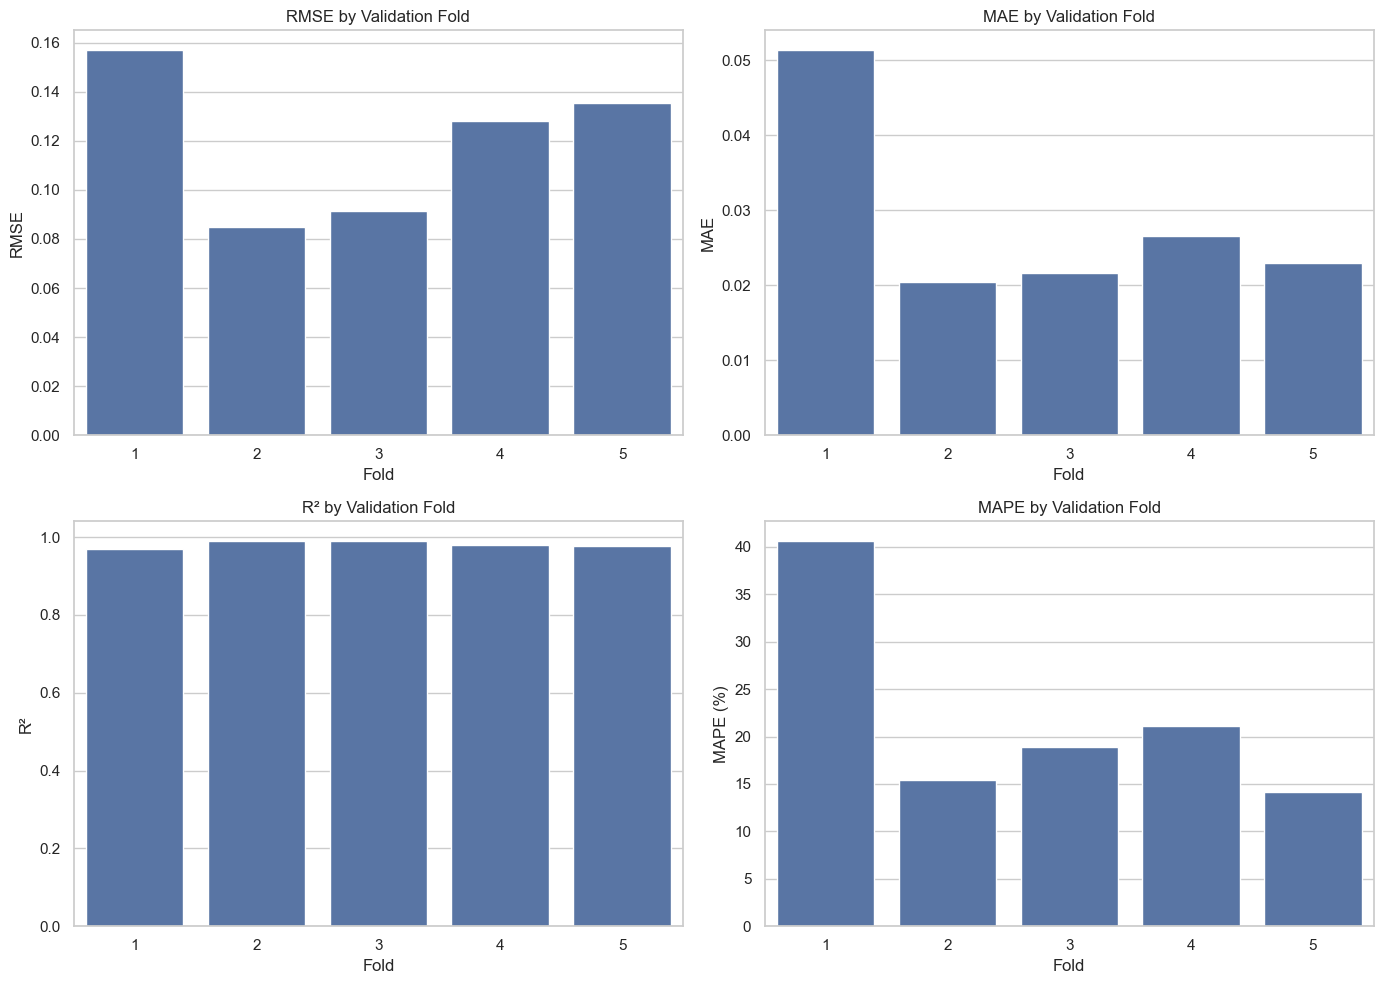

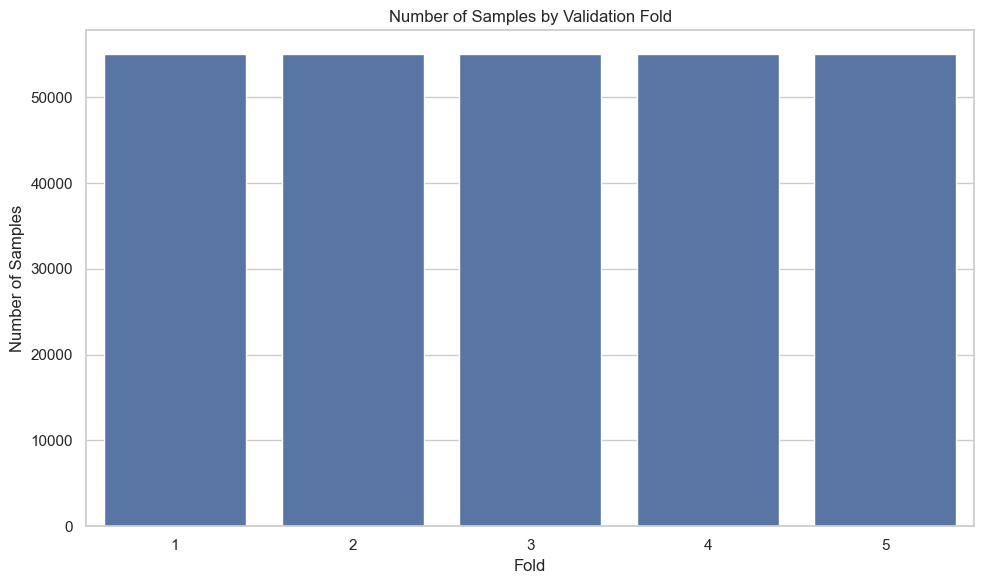

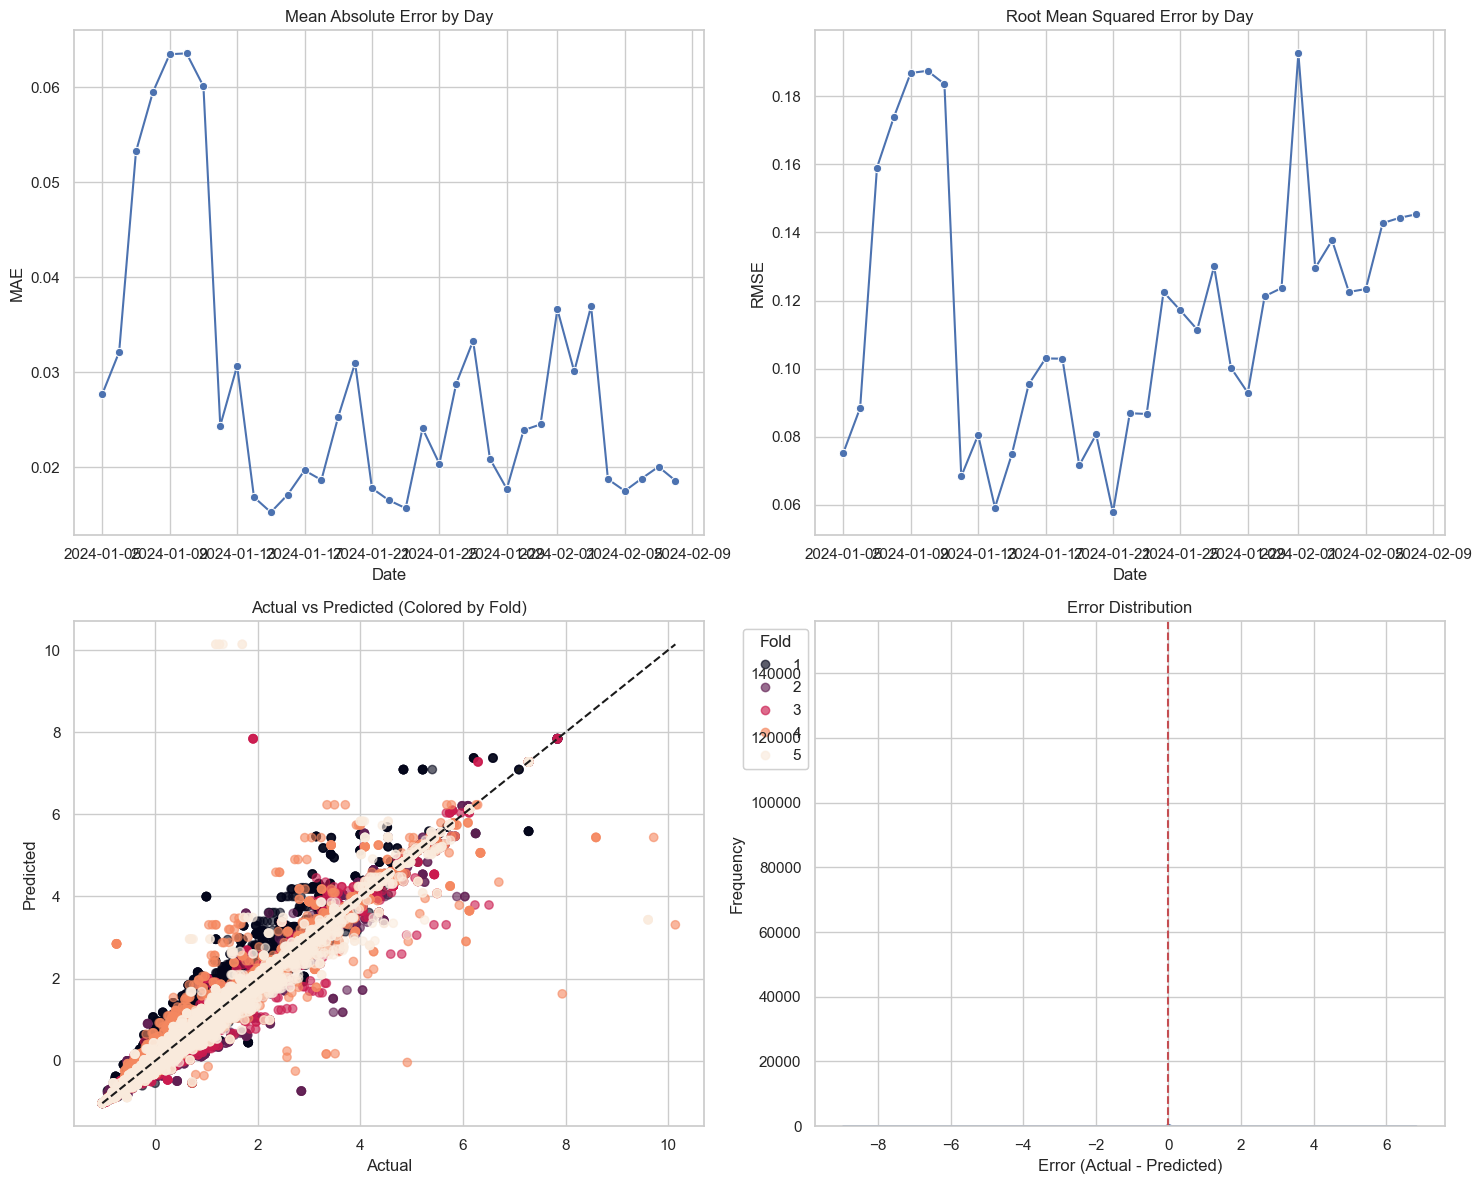

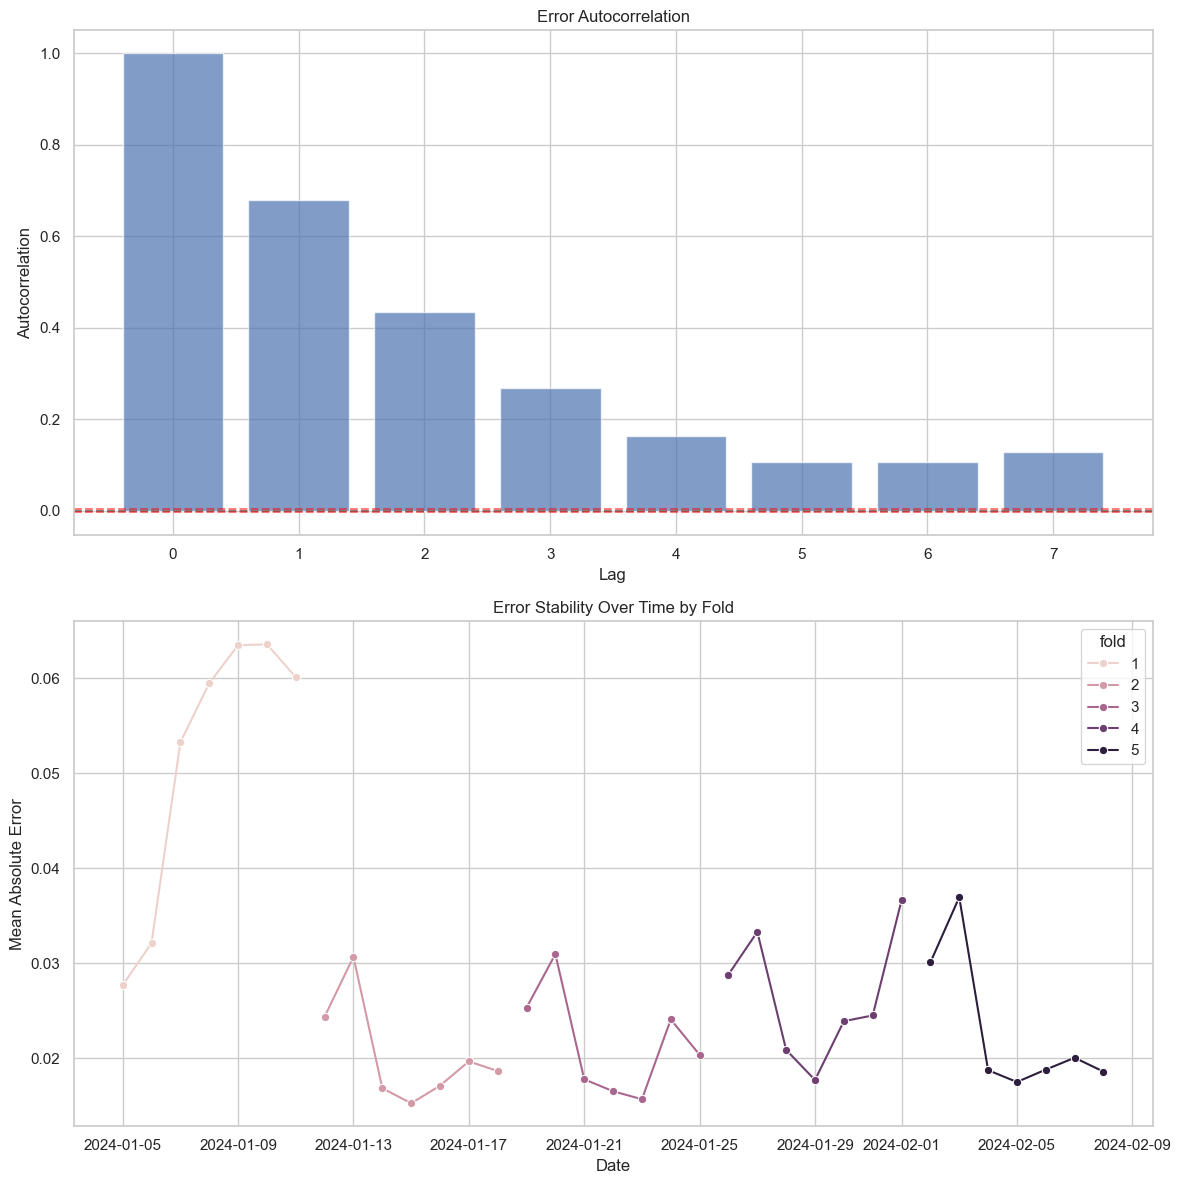


Naive baseline cross-validation analysis complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import os
from datetime import timedelta

# Set the style for plots
sns.set_theme(style="whitegrid")

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(daily_metrics_df):
    """
    Calculate error stability metrics:
    1. Consistency of MAE across days
    """
    # Calculate stability metrics
    mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()  # Lower is better
    
    return {
        'daily_mae': daily_metrics_df['mae'],
        'mae_stability_coefficient': mae_stability
    }

def run_naive_baseline_cv(data_path, validation_weeks=5, output_path=None):
    """
    Run naive baseline prediction (previous price) with time-based cross-validation.
    
    Parameters:
    data_path (str): Path to the CSV data file
    validation_weeks (int): Number of weeks to use as validation periods
    output_path (str, optional): Path to save results CSV
    """
    print(f"Running naive baseline with time-based CV using {validation_weeks} validation weeks")
    
    # Load data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Remove simulated_price column as specified
    if 'simulated_price' in data.columns:
        data = data.drop('simulated_price', axis=1)
    
    # Sort by date
    data = data.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate the duration of the dataset in days
    total_days = (max_date - min_date).days + 1
    print(f"Total duration: {total_days} days")
    
    # Calculate validation start date (validation_weeks before the end of the dataset)
    validation_start = max_date - timedelta(days=validation_weeks*7 - 1)
    
    # Define base training period as everything before validation start
    base_training_end = validation_start - timedelta(days=1)
    
    # Calculate validation week boundaries
    weeks = []
    for i in range(validation_weeks):
        week_start = validation_start + timedelta(days=i*7)
        week_end = week_start + timedelta(days=6)
        
        # Ensure we don't go beyond the dataset
        if week_end > max_date:
            week_end = max_date
        
        weeks.append((week_start, week_end))
    
    print("Time periods for cross-validation:")
    print(f"Base training period: {min_date.date()} to {base_training_end.date()}")
    for i, (start, end) in enumerate(weeks, 1):
        print(f"Validation fold {i}: {start.date()} to {end.date()}")
    
    # Initialize results storage
    fold_results = []
    
    # Run cross-validation
    for fold, (start_date, end_date) in enumerate(weeks, 1):
        print(f"\nProcessing fold {fold} ({start_date.date()} to {end_date.date()})...")
        
        # For the first fold, get last prices from base training period
        if fold == 1:
            # Get all data up to base training end
            train_data = data[(data['date'] >= min_date) & (data['date'] <= base_training_end)]
            
            # Get the last price from training data for each listing
            last_prices = train_data.groupby('listing_id').last()[['date', 'price']].reset_index()
            last_prices.rename(columns={'date': 'last_price_date', 'price': 'last_price'}, inplace=True)
        else:
            # For subsequent folds, include previous validation weeks in last price lookup
            previous_end = weeks[fold-2][1]  # End date of the previous validation fold
            
            # Get all data up to previous fold end
            prev_data = data[(data['date'] >= min_date) & (data['date'] <= previous_end)]
            
            # Get the last price for each listing
            last_prices = prev_data.groupby('listing_id').last()[['date', 'price']].reset_index()
            last_prices.rename(columns={'date': 'last_price_date', 'price': 'last_price'}, inplace=True)
        
        # Get validation data for this fold
        val_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].copy()
        
        # Check that we have data
        if len(val_data) == 0:
            print(f"Warning: No validation data for fold {fold}. Skipping.")
            continue
        
        # Merge with last known prices
        val_data = val_data.merge(last_prices, on='listing_id', how='left')
        
        # Check for missing last_price values
        missing_prices = val_data[val_data['last_price'].isna()]
        if len(missing_prices) > 0:
            print(f"Warning: {len(missing_prices)} listings in fold {fold} don't have a previous price. Using mean price.")
            # Fill with mean price
            mean_price = data[data['date'] <= base_training_end]['price'].mean()
            val_data['last_price'] = val_data['last_price'].fillna(mean_price)
        
        # Calculate naive predictions (use last known price)
        val_data['predicted'] = val_data['last_price']
        
        # Calculate errors
        val_data['error'] = val_data['price'] - val_data['predicted']
        val_data['abs_error'] = np.abs(val_data['error'])
        val_data['pct_error'] = (np.abs(val_data['error']) / val_data['price']) * 100
        
        # Add fold information
        val_data['fold'] = fold
        
        # Store results
        fold_results.append(val_data[['date', 'listing_id', 'price', 'predicted', 'error', 'abs_error', 'pct_error', 'fold', 'last_price_date']])
    
    # Combine all results
    all_results = pd.concat(fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate metrics for each fold
    fold_metrics = []
    for fold in range(1, validation_weeks + 1):
        fold_data = all_results[all_results['fold'] == fold]
        
        if len(fold_data) == 0:
            continue
        
        y_true_fold = fold_data['price'].values
        y_pred_fold = fold_data['predicted'].values
        
        fold_metrics.append({
            'fold': fold,
            'start_date': weeks[fold-1][0],
            'end_date': weeks[fold-1][1],
            'rmse': np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)),
            'mae': mean_absolute_error(y_true_fold, y_pred_fold),
            'r2': r2_score(y_true_fold, y_pred_fold) if len(set(y_true_fold)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_fold - y_pred_fold) / (y_true_fold + 1e-8))) * 100,
            'n_samples': len(y_true_fold)
        })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    # Add date_str column for grouping
    all_results['date_str'] = all_results['date'].dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(daily_metrics_df)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data if available
        if 'longitude' in data.columns and 'latitude' in data.columns:
            location_data = data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Also save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")

    return evaluation_results

def plot_fold_performance(evaluation_results):
    """Plot fold performance metrics"""
    fold_metrics = evaluation_results['fold_metrics']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: RMSE by fold
    sns.barplot(x='fold', y='rmse', data=fold_metrics, ax=axes[0, 0])
    axes[0, 0].set_title('RMSE by Validation Fold')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('RMSE')
    
    # Plot 2: MAE by fold
    sns.barplot(x='fold', y='mae', data=fold_metrics, ax=axes[0, 1])
    axes[0, 1].set_title('MAE by Validation Fold')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('MAE')
    
    # Plot 3: R² by fold
    sns.barplot(x='fold', y='r2', data=fold_metrics, ax=axes[1, 0])
    axes[1, 0].set_title('R² by Validation Fold')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('R²')
    
    # Plot 4: MAPE by fold
    sns.barplot(x='fold', y='mape', data=fold_metrics, ax=axes[1, 1])
    axes[1, 1].set_title('MAPE by Validation Fold')
    axes[1, 1].set_xlabel('Fold')
    axes[1, 1].set_ylabel('MAPE (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Create sample size plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='fold', y='n_samples', data=fold_metrics)
    plt.title('Number of Samples by Validation Fold')
    plt.xlabel('Fold')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['fold'],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Fold)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Fold", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE across folds)
    daily_metrics = evaluation_results['daily_metrics']
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        hue=daily_metrics['fold'],
        marker='o',
        ax=axes[1]
    )
    
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_title('Error Stability Over Time by Fold')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    fold_metrics = evaluation_results['fold_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== NAIVE BASELINE MODEL EVALUATION (Time-Based CV) =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Fold Performance ===")
    print(fold_metrics[['fold', 'start_date', 'end_date', 'rmse', 'mae', 'r2', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {fold_metrics['mae'].mean():.4f}")
    print(f"  Min: {fold_metrics['mae'].min():.4f} (Fold: {fold_metrics.loc[fold_metrics['mae'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['mae'].max():.4f} (Fold: {fold_metrics.loc[fold_metrics['mae'].idxmax(), 'fold']})")
    
    print("\nRMSE:")
    print(f"  Average: {fold_metrics['rmse'].mean():.4f}")
    print(f"  Min: {fold_metrics['rmse'].min():.4f} (Fold: {fold_metrics.loc[fold_metrics['rmse'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['rmse'].max():.4f} (Fold: {fold_metrics.loc[fold_metrics['rmse'].idxmax(), 'fold']})")
    
    print("\nMAPE:")
    print(f"  Average: {fold_metrics['mape'].mean():.2f}%")
    print(f"  Min: {fold_metrics['mape'].min():.2f}% (Fold: {fold_metrics.loc[fold_metrics['mape'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['mape'].max():.2f}% (Fold: {fold_metrics.loc[fold_metrics['mape'].idxmax(), 'fold']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

# Main execution
if __name__ == "__main__":
    # Specify path to your data
    data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\Topic2_Train.csv"
    
    # Specify output path for results CSV
    output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Topic2\naive_baseline_cv_results_T2.csv"
    
    # Run time-based cross-validation with naive baseline
    results = run_naive_baseline_cv(
        data_path=data_path,
        validation_weeks=5,     # Last 5 weeks as validation
        output_path=output_path
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_fold_performance(results)
    plot_results(results)
    plot_error_analysis(results)
    
    # Print completion message
    print("\nNaive baseline cross-validation analysis complete.")

Running naive baseline with time-based CV using 5 validation weeks
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days
Time periods for cross-validation:
Base training period: 2023-08-07 to 2024-01-04
Validation fold 1: 2024-01-05 to 2024-01-11
Validation fold 2: 2024-01-12 to 2024-01-18
Validation fold 3: 2024-01-19 to 2024-01-25
Validation fold 4: 2024-01-26 to 2024-02-01
Validation fold 5: 2024-02-02 to 2024-02-08

Processing fold 1 (2024-01-05 to 2024-01-11)...

Processing fold 2 (2024-01-12 to 2024-01-18)...

Processing fold 3 (2024-01-19 to 2024-01-25)...

Processing fold 4 (2024-01-26 to 2024-02-01)...

Processing fold 5 (2024-02-02 to 2024-02-08)...
Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\naive_baseline_cv_results.csv with location data
Fold metrics saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\naive_baseline_cv_results_fold_metrics.csv
Daily metrics saved to C:\Users\matth\OneDrive\Document

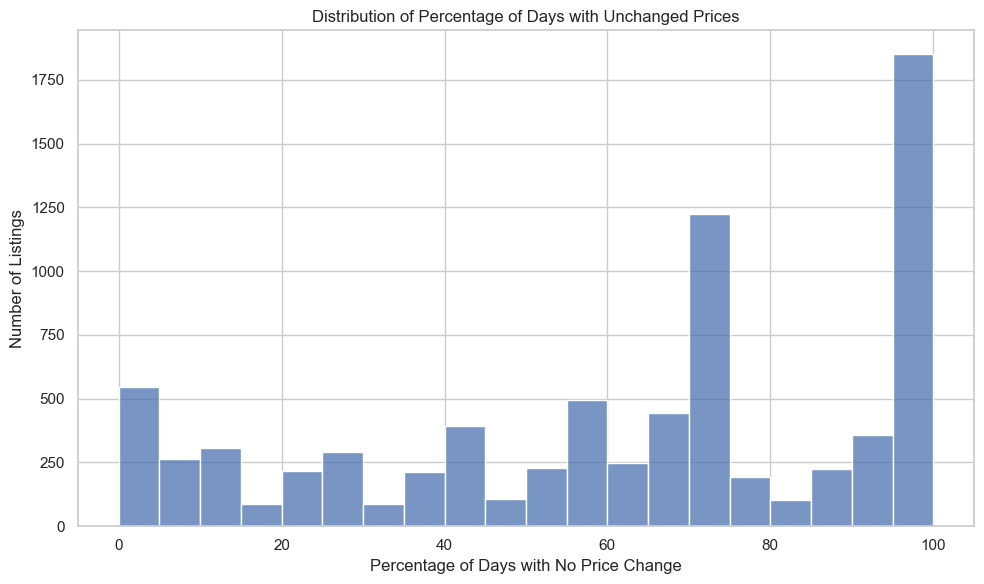

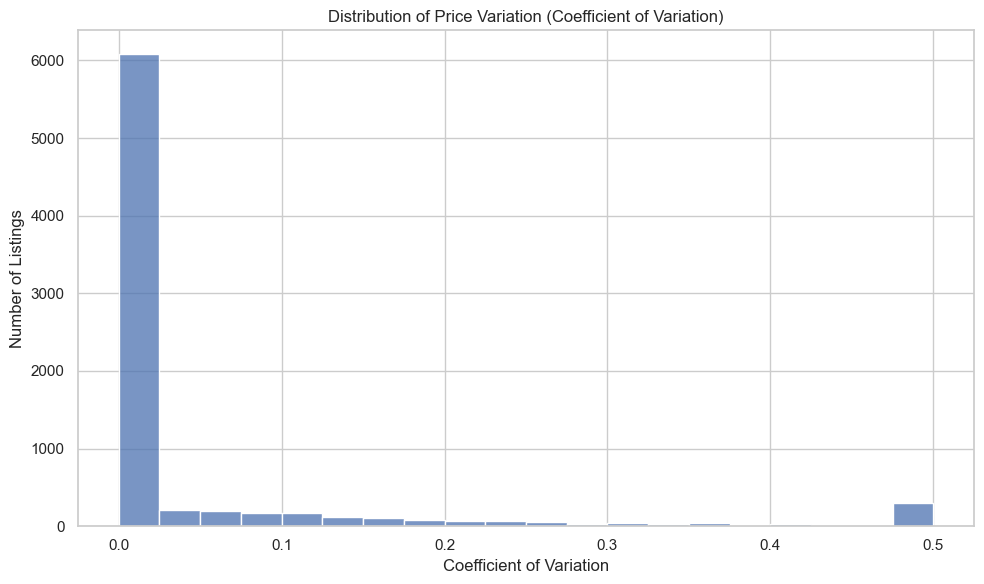


=== Feature Correlation with Prediction Errors ===

Features most correlated with absolute error:
rolling_max_30d     0.588787
rolling_max_14d     0.569521
rolling_max_7d      0.535632
price_lag_7d        0.496088
rolling_mean_30d    0.472275
rolling_mean_14d    0.468535
rolling_mean_7d     0.458054
price_lag_1d        0.445006
price_lag_30d       0.439871
rolling_min_7d      0.422022

Features least correlated with absolute error:
has_kitchen       -0.014891
latitude          -0.015694
has_washer        -0.044865
longitude         -0.077016
error             -0.525994
DTF_day_of_week         NaN
DTF_month               NaN
DTF_is_weekend          NaN
DTF_season_sin          NaN
DTF_season_cos          NaN


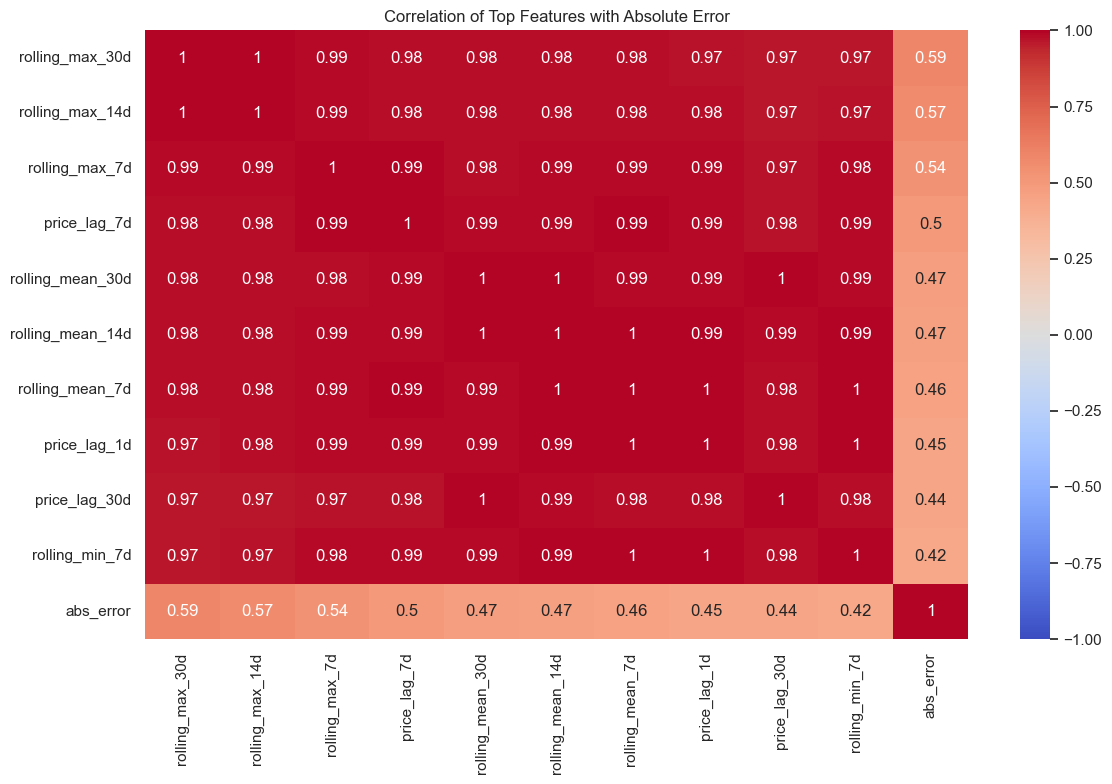

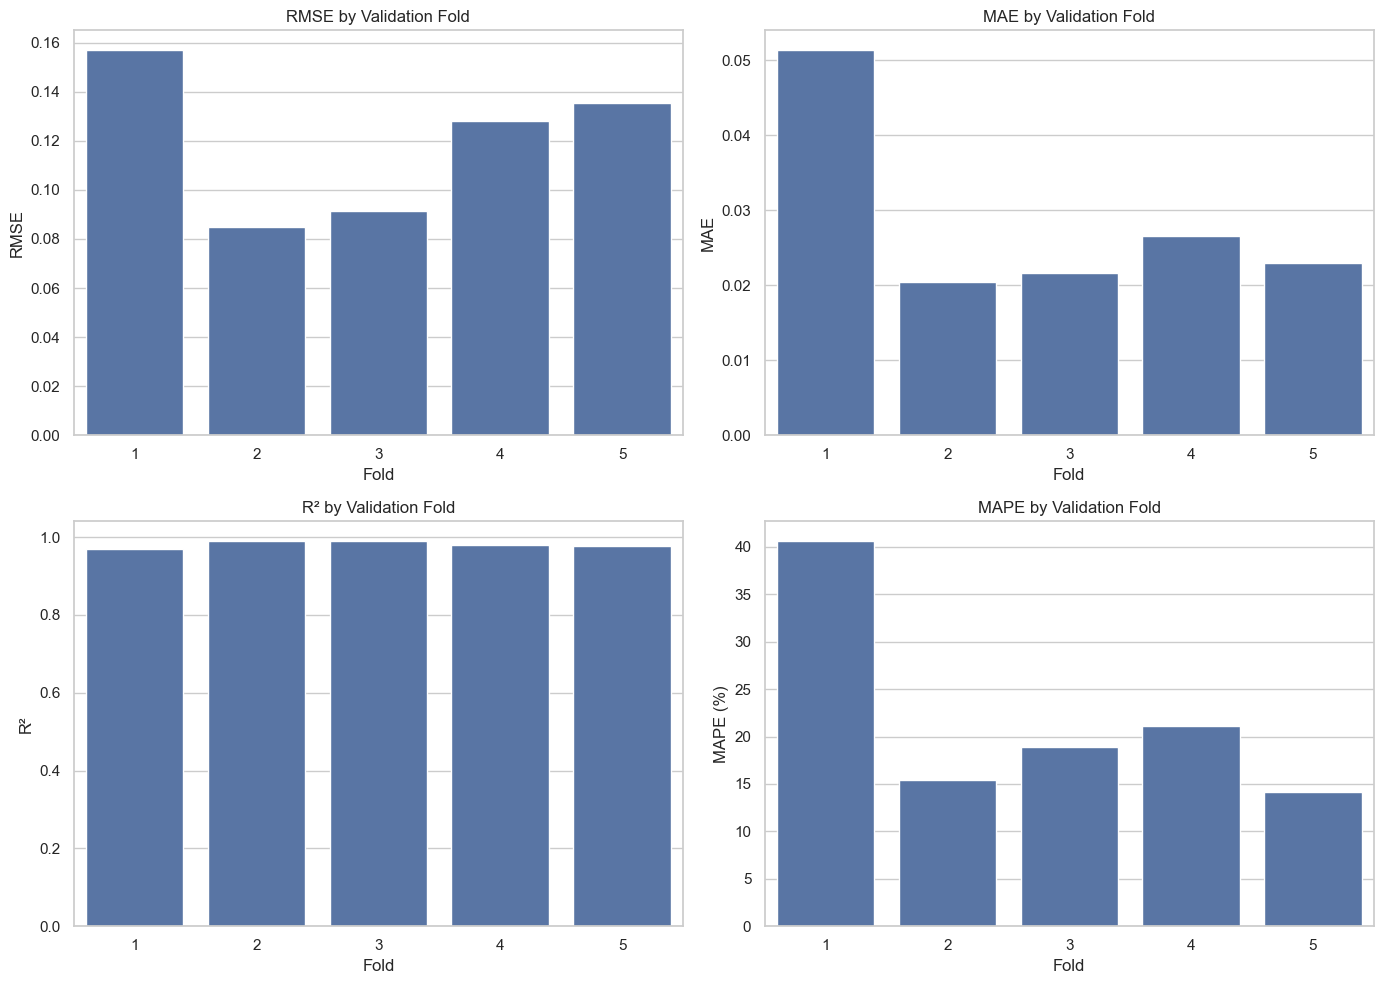

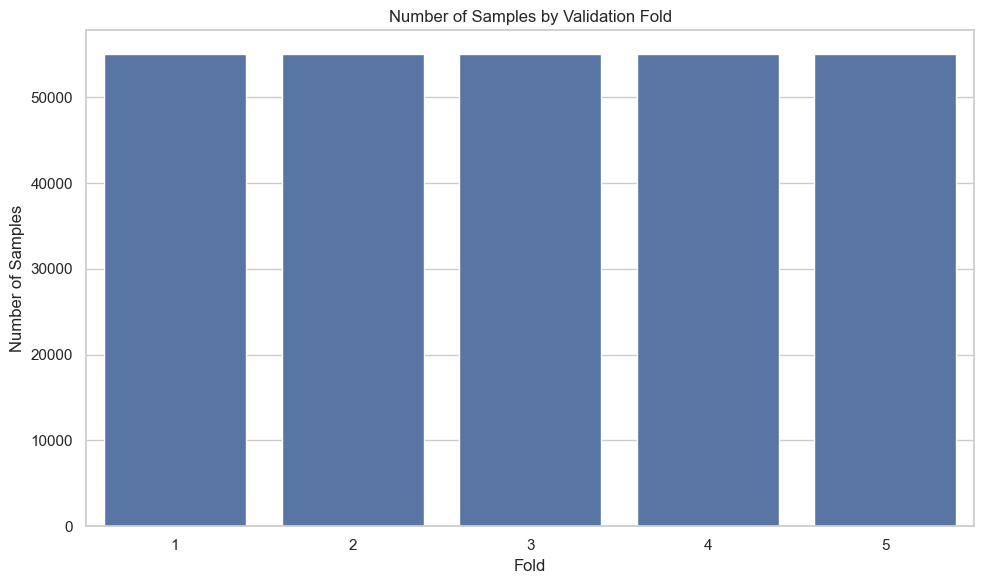

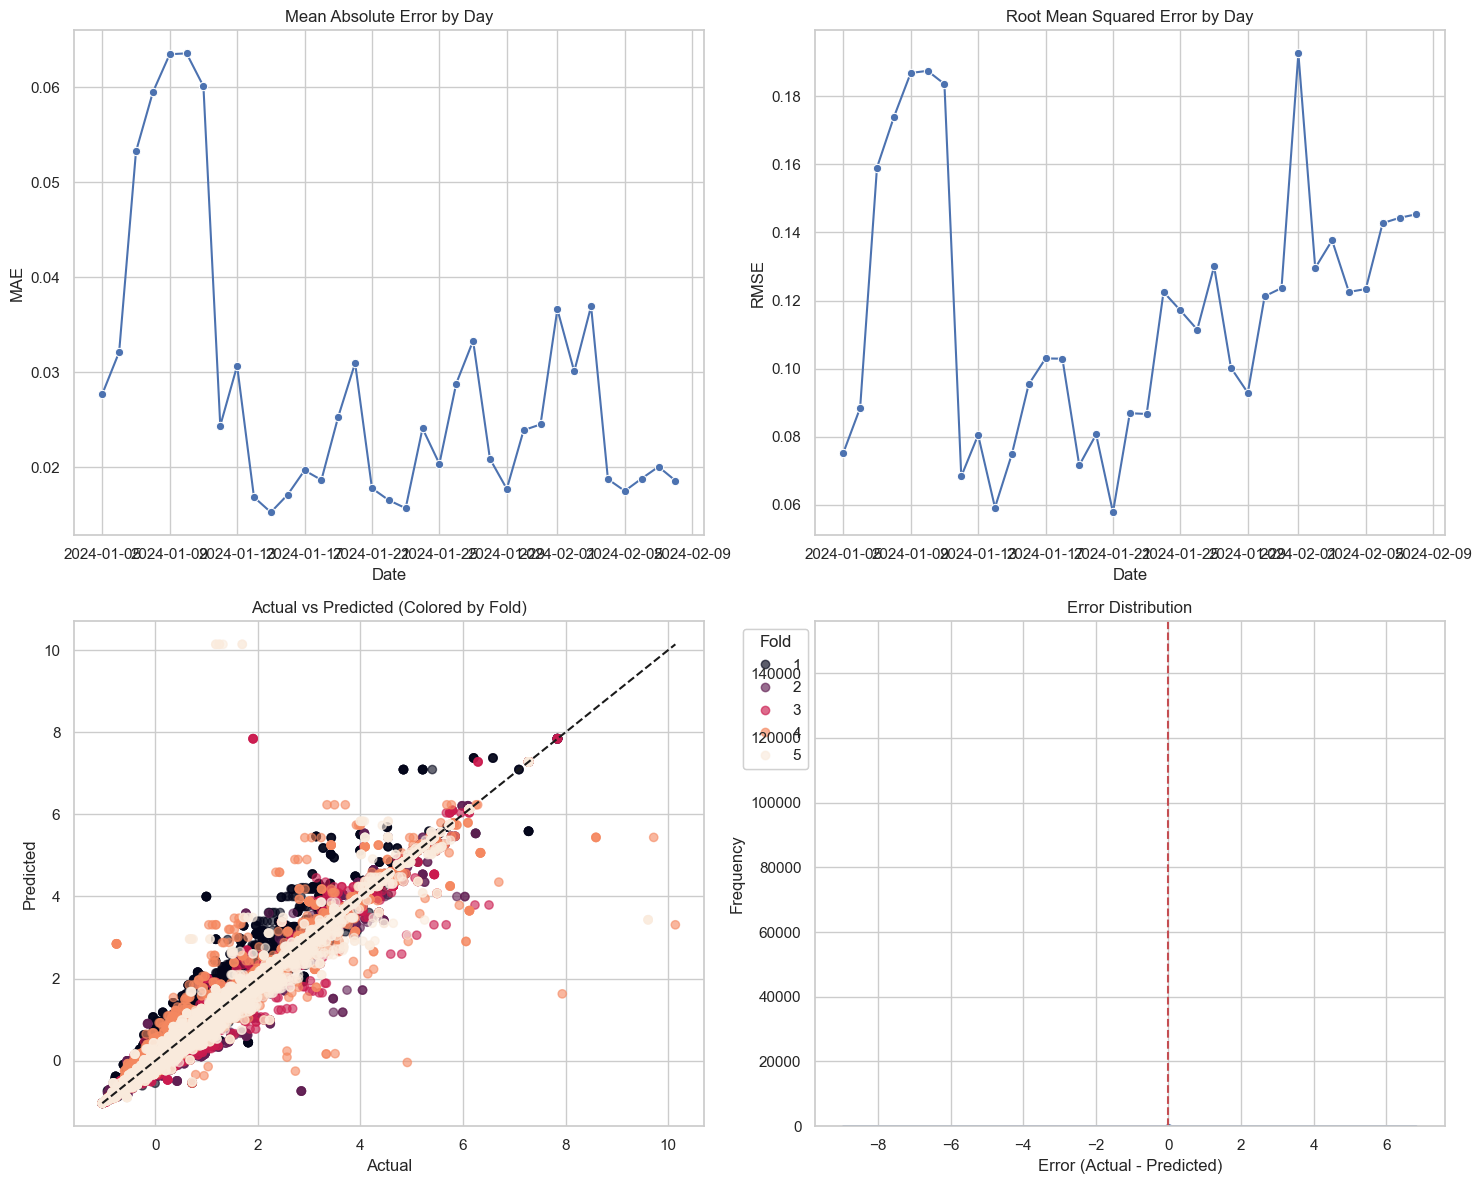

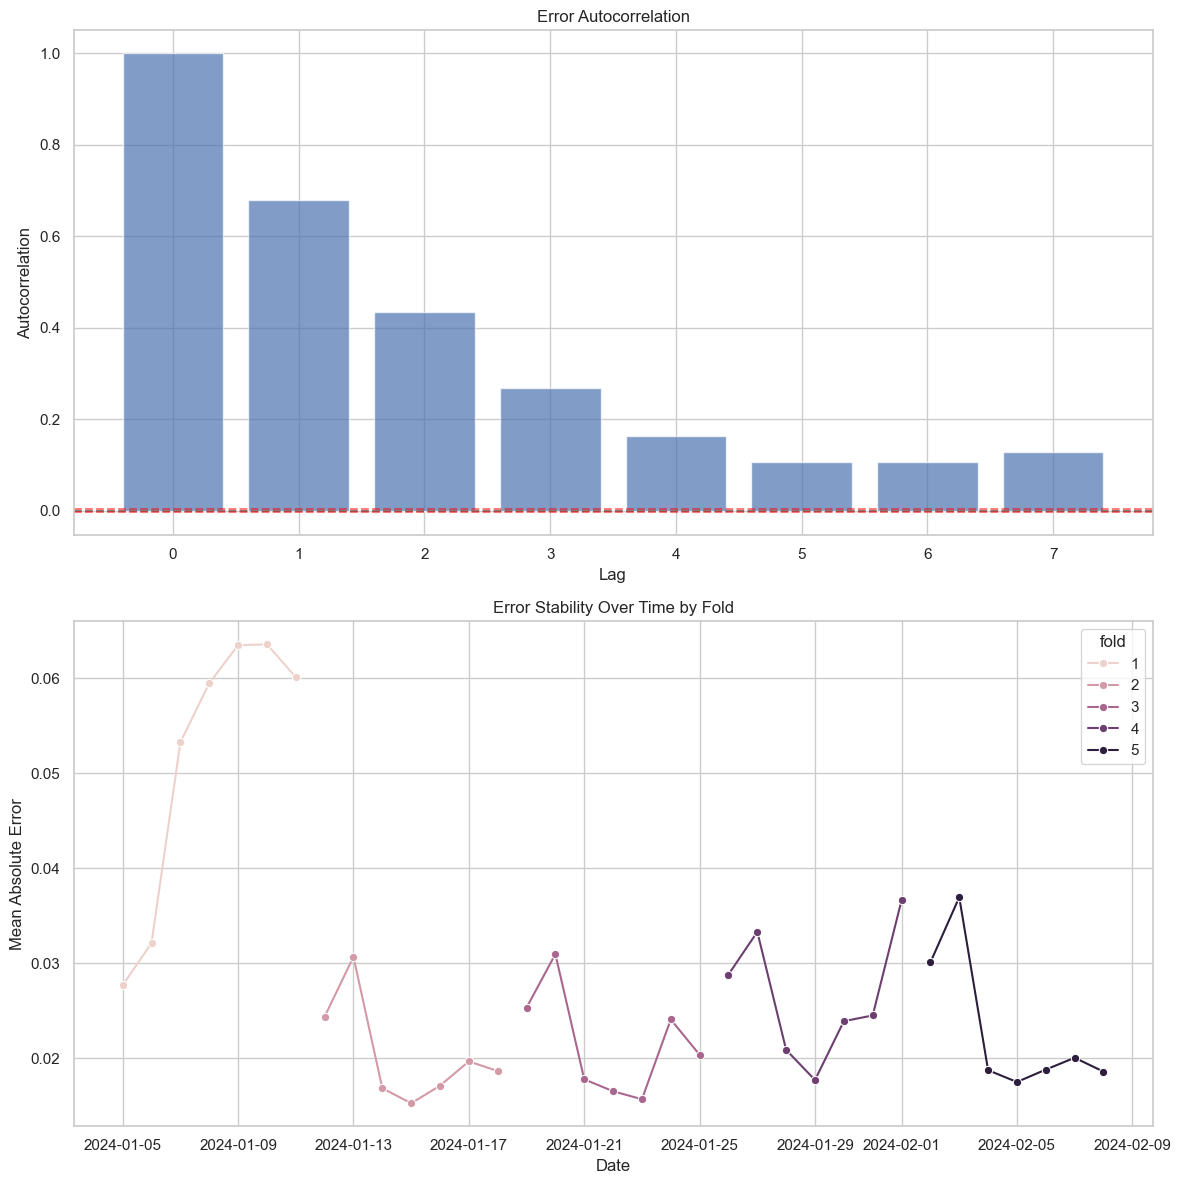


Naive baseline cross-validation analysis complete.


In [3]:
def analyze_price_stability(all_results):
    """
    Analyze the stability of prices to understand why R² might be high
    """
    # Calculate price changes between consecutive observations for each listing
    changes_data = []
    
    # Group by listing_id and calculate statistics
    listing_groups = all_results.sort_values(['listing_id', 'date']).groupby('listing_id')
    
    for listing_id, group in listing_groups:
        if len(group) <= 1:
            continue
            
        # Calculate price changes
        price_diffs = group['price'].diff().dropna()
        
        # Calculate statistics
        changes_data.append({
            'listing_id': listing_id,
            'mean_abs_change': price_diffs.abs().mean(),
            'max_abs_change': price_diffs.abs().max(),
            'pct_days_unchanged': (price_diffs == 0).mean() * 100,
            'price_std': group['price'].std(),
            'price_mean': group['price'].mean(),
            'cv': group['price'].std() / group['price'].mean() if group['price'].mean() > 0 else 0
        })
    
    changes_df = pd.DataFrame(changes_data)
    
    # Print summary statistics
    print("\n=== Price Stability Analysis ===")
    print(f"Average percentage of days with unchanged prices: {changes_df['pct_days_unchanged'].mean():.2f}%")
    print(f"Average coefficient of variation: {changes_df['cv'].mean():.4f}")
    print(f"Average absolute price change: {changes_df['mean_abs_change'].mean():.4f}")
    print(f"Percentage of listings with no price changes: {(changes_df['mean_abs_change'] == 0).mean() * 100:.2f}%")
    
    # Create histogram of price changes
    plt.figure(figsize=(10, 6))
    sns.histplot(changes_df['pct_days_unchanged'], bins=20)
    plt.title('Distribution of Percentage of Days with Unchanged Prices')
    plt.xlabel('Percentage of Days with No Price Change')
    plt.ylabel('Number of Listings')
    plt.tight_layout()
    plt.show()
    
    # Create histogram of coefficient of variation
    plt.figure(figsize=(10, 6))
    sns.histplot(changes_df['cv'].clip(0, 0.5), bins=20)  # Clip to focus on main distribution
    plt.title('Distribution of Price Variation (Coefficient of Variation)')
    plt.xlabel('Coefficient of Variation')
    plt.ylabel('Number of Listings')
    plt.tight_layout()
    plt.show()
    
    return changes_df

def analyze_prediction_error_by_feature(all_results, data_path):
    """
    Analyze how prediction errors relate to different features
    """
    # Load the full dataset to get access to all features
    full_data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    full_data['date'] = pd.to_datetime(full_data['date'])
    
    # Remove simulated_price column if it exists
    if 'simulated_price' in full_data.columns:
        full_data = full_data.drop('simulated_price', axis=1)
    
    # Get a subset of the most recent data point for each listing to analyze features
    latest_data = full_data.sort_values('date').groupby('listing_id').last().reset_index()
    
    # Merge with results to get prediction errors
    merged_data = all_results[['listing_id', 'error', 'abs_error', 'pct_error']].groupby('listing_id').mean().reset_index()
    analysis_data = latest_data.merge(merged_data, on='listing_id', how='inner')
    
    # Identify potential numerical features for correlation analysis
    id_date_cols = ['listing_id', 'date']
    target_col = 'price'
    drop_cols = id_date_cols + [target_col, 'error', 'abs_error', 'pct_error']
    
    # Try to identify numerical features
    numerical_features = []
    for col in analysis_data.columns:
        if col in drop_cols:
            continue
        try:
            # Check if column can be converted to numeric
            pd.to_numeric(analysis_data[col])
            numerical_features.append(col)
        except:
            continue
    
    # Calculate correlations between numerical features and error metrics
    if numerical_features:
        print("\n=== Feature Correlation with Prediction Errors ===")
        correlation_data = analysis_data[numerical_features + ['error', 'abs_error', 'pct_error']]
        
        # Calculate correlations with absolute error
        corr_with_abs_error = correlation_data.corr()['abs_error'].sort_values(ascending=False)
        
        # Print top correlations
        print("\nFeatures most correlated with absolute error:")
        print(corr_with_abs_error[corr_with_abs_error.index != 'abs_error'].head(10).to_string())
        
        # Print bottom correlations
        print("\nFeatures least correlated with absolute error:")
        print(corr_with_abs_error[corr_with_abs_error.index != 'abs_error'].tail(10).to_string())
        
        # Visualize top correlations
        plt.figure(figsize=(12, 8))
        top_features = corr_with_abs_error[(corr_with_abs_error.index != 'abs_error') & 
                                           (corr_with_abs_error.index != 'error') & 
                                           (corr_with_abs_error.index != 'pct_error')].head(10).index
        
        corr_subset = correlation_data[list(top_features) + ['abs_error']].corr()
        sns.heatmap(corr_subset, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation of Top Features with Absolute Error')
        plt.tight_layout()
        plt.show()
    else:
        print("No suitable numerical features found for correlation analysis")
    
    return analysis_data

# Add these function calls to your main execution code
if __name__ == "__main__":
    # ... [existing code] ...
    
    # Run time-based cross-validation with naive baseline
    results = run_naive_baseline_cv(
        data_path=data_path,
        validation_weeks=5,
        output_path=output_path
    )
    
    # Print summary and plot results
    print_summary(results)
    
    # Analyze price stability
    stability_analysis = analyze_price_stability(results['all_results'])
    
    # Analyze prediction errors by feature
    error_by_feature = analyze_prediction_error_by_feature(results['all_results'], data_path)
    
    # Continue with other visualizations
    plot_fold_performance(results)
    plot_results(results)
    plot_error_analysis(results)
    
    # Print completion message
    print("\nNaive baseline cross-validation analysis complete.")

### Topic 2 naive Baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
import os
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

def run_naive_baseline_simulated_cv(data_path, validation_weeks=5, n_folds=5, output_path=None):
    """
    Run naive baseline prediction using simulated prices with time-based rolling window cross-validation.
    
    Parameters:
    data_path (str): Path to the CSV data file
    validation_weeks (int): Number of weeks for each validation fold
    n_folds (int): Number of time-based CV folds
    output_path (str, optional): Path to save results CSV
    """
    print(f"Running naive baseline with simulated prices using {n_folds} time-based CV folds")
    
    # Load data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Ensure we have the needed columns
    required_columns = ['listing_id', 'date', 'simulated_price', 'price']
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"Missing required columns: {missing}")
    
    # Identify potential feature columns (exclude target, IDs, and date)
    feature_cols = [col for col in data.columns 
                   if col not in ['listing_id', 'date', 'simulated_price', 'price', 
                                 'date_only', 'fold', 'previous_simulated_price', 
                                 'predicted_simulated', 'error', 'abs_error', 'pct_error']]
    
    print(f"Identified {len(feature_cols)} potential feature columns")
    
    # Sort by date
    data = data.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7
    
    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Ensure we have enough data for the requested folds
    min_weeks_needed = n_folds + validation_weeks - 1
    if weeks_available < min_weeks_needed:
        raise ValueError(f"Not enough data for {n_folds} folds with {validation_weeks} validation weeks each. "
                        f"Need at least {min_weeks_needed} weeks, but have {weeks_available} weeks.")
    
    # Create time-based folds
    folds = []
    # Step size in weeks (how much to move the window each time)
    step_size = max(1, (weeks_available - validation_weeks) // (n_folds - 1)) if n_folds > 1 else 1
    
    for i in range(n_folds):
        # Calculate validation start date for this fold
        val_start_offset = i * step_size * 7  # in days
        val_start = max_date - timedelta(days=(validation_weeks*7 - 1)) - timedelta(days=val_start_offset)
        val_end = val_start + timedelta(days=validation_weeks*7 - 1)
        
        # Ensure we don't go beyond dataset boundaries
        if val_end > max_date:
            val_end = max_date
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Initialize results storage
    fold_results = []
    feature_importance_results = []
    
    # Calculate previous day's simulated price for each listing
    data['previous_simulated_price'] = data.groupby('listing_id')['simulated_price'].shift(1)
    
    # Run cross-validation
    for fold_info in folds:
        fold = fold_info['fold']
        train_start = fold_info['train_start']
        train_end = fold_info['train_end']
        val_start = fold_info['val_start']
        val_end = fold_info['val_end']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {train_start.date()} to {train_end.date()}, "
              f"Val: {val_start.date()} to {val_end.date()})...")
        
        # Get training and validation data
        train_data = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
        val_data = data[(data['date'] >= val_start) & (data['date'] <= val_end)].copy()
        
        # Check that we have data
        if len(val_data) == 0:
            print(f"Warning: No validation data for fold {fold}. Skipping.")
            continue
        
        # For the first day of each listing in the validation period, we need to find the last simulated price
        # Create a mapping of last simulated prices from training data
        last_sim_prices = {}
        for listing_id in val_data['listing_id'].unique():
            listing_train = train_data[train_data['listing_id'] == listing_id].sort_values('date', ascending=False)
            if len(listing_train) > 0:
                last_sim_prices[listing_id] = listing_train.iloc[0]['simulated_price']
        
        # Fill in missing previous simulated prices in validation data
        for idx, row in val_data[val_data['previous_simulated_price'].isna()].iterrows():
            listing_id = row['listing_id']
            if listing_id in last_sim_prices:
                val_data.loc[idx, 'previous_simulated_price'] = last_sim_prices[listing_id]
            else:
                # If no training data for this listing, use mean simulated price
                mean_sim_price = train_data['simulated_price'].mean()
                val_data.loc[idx, 'previous_simulated_price'] = mean_sim_price
        
        # Use previous day's simulated price as the prediction for current day's simulated price
        val_data['predicted_simulated'] = val_data['previous_simulated_price']
        
        # Calculate errors against the actual price (not the simulated price)
        val_data['error'] = val_data['price'] - val_data['predicted_simulated']
        val_data['abs_error'] = np.abs(val_data['error'])
        val_data['pct_error'] = (np.abs(val_data['error']) / np.abs(val_data['price'] + 1e-8)) * 100
        
        # Add fold information
        val_data['fold'] = fold
        
        # Store results
        fold_results.append(val_data[['date', 'listing_id', 'price', 'simulated_price', 
                                    'predicted_simulated', 'error', 'abs_error', 'pct_error', 'fold']])
        
        # Feature importance analysis using a simple linear model
        if len(feature_cols) > 0:
            # Only include rows with valid features and target
            valid_features = val_data.dropna(subset=feature_cols + ['price', 'predicted_simulated'])
            
            if len(valid_features) > 0:
                # Train a linear model to predict the error
                X = valid_features[feature_cols]
                y = valid_features['error']  # We're trying to predict the error of our naive model
                
                try:
                    # Train model and get feature importances
                    model = LinearRegression()
                    model.fit(X, y)
                    
                    # Get feature importances
                    importances = np.abs(model.coef_)
                    importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': importances,
                        'fold': fold
                    })
                    feature_importance_results.append(importance_df)
                    
                    # Also try permutation importance for more robust results
                    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
                    perm_importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': perm_importance.importances_mean,
                        'fold': fold,
                        'method': 'permutation'
                    })
                    feature_importance_results.append(perm_importance_df)
                    
                except Exception as e:
                    print(f"Warning: Could not calculate feature importance for fold {fold}: {e}")
    
    # Combine all results
    all_results = pd.concat(fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_simulated'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    }
    
    # Calculate metrics for each fold
    fold_metrics = []
    for fold in range(1, n_folds + 1):
        fold_data = all_results[all_results['fold'] == fold]
        
        if len(fold_data) == 0:
            continue
        
        y_true_fold = fold_data['price'].values
        y_pred_fold = fold_data['predicted_simulated'].values
        
        fold_metrics.append({
            'fold': fold,
            'start_date': fold_data['date'].min(),
            'end_date': fold_data['date'].max(),
            'rmse': np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)),
            'mae': mean_absolute_error(y_true_fold, y_pred_fold),
            'r2': r2_score(y_true_fold, y_pred_fold) if len(set(y_true_fold)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_fold - y_pred_fold) / (np.abs(y_true_fold) + 1e-8))) * 100,
            'n_samples': len(y_true_fold)
        })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_simulated'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (np.abs(y_true_day) + 1e-8))) * 100,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Process feature importance results
    if feature_importance_results:
        feature_importance_df = pd.concat(feature_importance_results, ignore_index=True)
        
        # Calculate average importance across folds
        avg_importance = feature_importance_df.groupby(['feature', 'method'] 
                                                     if 'method' in feature_importance_df.columns 
                                                     else 'feature')['importance'].mean().reset_index()
        avg_importance = avg_importance.sort_values('importance', ascending=False)
    else:
        avg_importance = pd.DataFrame(columns=['feature', 'importance'])
        feature_importance_df = pd.DataFrame(columns=['feature', 'importance', 'fold'])
    
    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)
    
    # Calculate error stability metrics
    error_stability = calculate_error_stability(daily_metrics_df)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability,
        'feature_importance': avg_importance,
        'feature_importance_by_fold': feature_importance_df
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Also save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Also save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
        
        # Save feature importance
        if len(feature_importance_df) > 0:
            feature_path = output_path.replace('.csv', '_feature_importance.csv')
            avg_importance.to_csv(feature_path, index=False)
            print(f"Feature importance saved to {feature_path}")
    
    return evaluation_results

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(daily_metrics_df):
    """
    Calculate error stability metrics:
    1. Consistency of MAE across days
    """
    # Calculate stability metrics
    mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()  # Lower is better
    
    return {
        'daily_mae': daily_metrics_df['mae'],
        'mae_stability_coefficient': mae_stability
    }

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    fold_metrics = evaluation_results['fold_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== NAIVE BASELINE MODEL EVALUATION (Time-Based CV with Simulated Prices) =====")
    print("\nPrediction approach: Predict simulated_price using previous day's simulated_price")
    print("Evaluation metric: Compare predicted simulated_price against actual price")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Fold Performance ===")
    print(fold_metrics[['fold', 'start_date', 'end_date', 'rmse', 'mae', 'r2', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {fold_metrics['mae'].mean():.4f}")
    print(f"  Min: {fold_metrics['mae'].min():.4f} (Fold: {fold_metrics.loc[fold_metrics['mae'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['mae'].max():.4f} (Fold: {fold_metrics.loc[fold_metrics['mae'].idxmax(), 'fold']})")
    
    print("\nRMSE:")
    print(f"  Average: {fold_metrics['rmse'].mean():.4f}")
    print(f"  Min: {fold_metrics['rmse'].min():.4f} (Fold: {fold_metrics.loc[fold_metrics['rmse'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['rmse'].max():.4f} (Fold: {fold_metrics.loc[fold_metrics['rmse'].idxmax(), 'fold']})")
    
    print("\nMAPE:")
    print(f"  Average: {fold_metrics['mape'].mean():.2f}%")
    print(f"  Min: {fold_metrics['mape'].min():.2f}% (Fold: {fold_metrics.loc[fold_metrics['mape'].idxmin(), 'fold']})")
    print(f"  Max: {fold_metrics['mape'].max():.2f}% (Fold: {fold_metrics.loc[fold_metrics['mape'].idxmax(), 'fold']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")
    
    # Print feature importance if available
    if 'feature_importance' in evaluation_results and len(evaluation_results['feature_importance']) > 0:
        print("\n=== Top 10 Feature Importance ===")
        top_features = evaluation_results['feature_importance'].head(10)
        for _, row in top_features.iterrows():
            if 'method' in row:
                print(f"  {row['feature']} ({row['method']}): {row['importance']:.4f}")
            else:
                print(f"  {row['feature']}: {row['importance']:.4f}")

def plot_fold_performance(evaluation_results):
    """Plot fold performance metrics"""
    fold_metrics = evaluation_results['fold_metrics']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: RMSE by fold
    sns.barplot(x='fold', y='rmse', data=fold_metrics, ax=axes[0, 0])
    axes[0, 0].set_title('RMSE by Validation Fold')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('RMSE')
    
    # Plot 2: MAE by fold
    sns.barplot(x='fold', y='mae', data=fold_metrics, ax=axes[0, 1])
    axes[0, 1].set_title('MAE by Validation Fold')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('MAE')
    
    # Plot 3: R² by fold
    sns.barplot(x='fold', y='r2', data=fold_metrics, ax=axes[1, 0])
    axes[1, 0].set_title('R² by Validation Fold')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('R²')
    
    # Plot 4: MAPE by fold
    sns.barplot(x='fold', y='mape', data=fold_metrics, ax=axes[1, 1])
    axes[1, 1].set_title('MAPE by Validation Fold')
    axes[1, 1].set_xlabel('Fold')
    axes[1, 1].set_ylabel('MAPE (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Create sample size plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='fold', y='n_samples', data=fold_metrics)
    plt.title('Number of Samples by Validation Fold')
    plt.xlabel('Fold')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

def plot_time_series_metrics(evaluation_results):
    """Plot time series metrics by day"""
    daily_metrics = evaluation_results['daily_metrics']
    
    # Convert date to datetime for better plotting
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Daily MAE
    sns.lineplot(x='date', y='mae', data=daily_metrics, marker='o', ax=axes[0, 0])
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Daily RMSE
    sns.lineplot(x='date', y='rmse', data=daily_metrics, marker='o', ax=axes[0, 1])
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Daily R²
    sns.lineplot(x='date', y='r2', data=daily_metrics, marker='o', ax=axes[1, 0])
    axes[1, 0].set_title('R² by Day')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Daily MAPE
    sns.lineplot(x='date', y='mape', data=daily_metrics, marker='o', ax=axes[1, 1])
    axes[1, 1].set_title('MAPE by Day')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Plot daily metrics by fold
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='date', y='mae', hue='fold', data=daily_metrics, marker='o')
    plt.title('MAE by Day and Fold')
    plt.xlabel('Date')
    plt.ylabel('MAE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(evaluation_results):
    """Plot feature importance"""
    if 'feature_importance' not in evaluation_results or len(evaluation_results['feature_importance']) == 0:
        print("No feature importance data available")
        return
    
    feature_importance = evaluation_results['feature_importance']
    
    # Get top features
    top_n = min(20, len(feature_importance))
    
    # If 'method' is in columns, split by method
    if 'method' in feature_importance.columns:
        methods = feature_importance['method'].unique()
        
        fig, axes = plt.subplots(len(methods), 1, figsize=(12, 6*len(methods)))
        
        # Handle single method case
        if len(methods) == 1:
            axes = [axes]
        
        for i, method in enumerate(methods):
            method_data = feature_importance[feature_importance['method'] == method]
            top_features = method_data.nlargest(top_n, 'importance')
            
            # Sort by importance for better visualization
            top_features = top_features.sort_values('importance')
            
            sns.barplot(x='importance', y='feature', data=top_features, ax=axes[i])
            axes[i].set_title(f'Top {top_n} Feature Importance ({method})')
            axes[i].set_xlabel('Importance')
            axes[i].set_ylabel('Feature')
    else:
        # Get top features
        top_features = feature_importance.nlargest(top_n, 'importance')
        
        # Sort by importance for better visualization
        top_features = top_features.sort_values('importance')
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=top_features)
        plt.title(f'Top {top_n} Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
    
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance by fold
    feature_by_fold = evaluation_results['feature_importance_by_fold']
    
    if len(feature_by_fold) > 0:
        # Get top 5 features
        top_5_features = feature_importance.nlargest(5, 'importance')['feature'].tolist()
        
        # Filter feature_by_fold for only these features
        top_features_by_fold = feature_by_fold[feature_by_fold['feature'].isin(top_5_features)]
        
        plt.figure(figsize=(14, 8))
        
        # If method exists, handle it
        if 'method' in top_features_by_fold.columns:
            # Filter for one method for simplicity
            method = top_features_by_fold['method'].iloc[0] if len(top_features_by_fold) > 0 else None
            if method:
                top_features_by_fold = top_features_by_fold[top_features_by_fold['method'] == method]
                title_suffix = f" ({method})"
            else:
                title_suffix = ""
        else:
            title_suffix = ""
        
        # Plot
        sns.lineplot(x='fold', y='importance', hue='feature', data=top_features_by_fold, marker='o')
        plt.title(f'Top 5 Feature Importance by Fold{title_suffix}')
        plt.xlabel('Fold')
        plt.ylabel('Importance')
        plt.xticks(top_features_by_fold['fold'].unique())
        plt.legend(title='Feature')
        plt.tight_layout()
        plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error analysis (autocorrelation and error distribution)"""
    all_results = evaluation_results['all_results']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1])
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_title('Error Distribution')
    axes[1].set_xlabel('Error (Actual - Predicted)')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Plot error by listing (boxplot of top 20 listings by error)
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    top_listings = listing_errors.nlargest(20, 'abs_error')['listing_id'].tolist()
    
    plt.figure(figsize=(15, 6))
    top_listings_data = all_results[all_results['listing_id'].isin(top_listings)]
    sns.boxplot(x='listing_id', y='abs_error', data=top_listings_data)
    plt.title('Absolute Error Distribution for Top 20 Listings with Highest Errors')
    plt.xlabel('Listing ID')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=90)
    plt.tight_layout
    plt.show()

def plot_comparison_by_listing(evaluation_results):
    #Plot comparison between actual prices, simulated prices, and predictions for specific listings
    all_results = evaluation_results['all_results']
    
    # Select a few random listings for visualization
    listing_ids = all_results['listing_id'].unique()
    sample_listings = np.random.choice(listing_ids, min(5, len(listing_ids)), replace=False)
    
    for sample_listing in sample_listings:
        # Get data for the sample listing
        listing_data = all_results[all_results['listing_id'] == sample_listing].sort_values('date')
        
        if len(listing_data) == 0:
            continue
            
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot prices over time
        plt.plot(listing_data['date'], listing_data['price'], 'o-', label='Actual Price')
        plt.plot(listing_data['date'], listing_data['simulated_price'], 'o-', label='Simulated Price')
        plt.plot(listing_data['date'], listing_data['predicted_simulated'], 'o-', label='Predicted Price')
        
        plt.title(f'Price Comparison for Listing {sample_listing}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def plot_actual_vs_predicted(evaluation_results):
    """Plot actual vs predicted prices with fold coloring"""
    all_results = evaluation_results['all_results']
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot of actual vs predicted
    scatter = plt.scatter(all_results['price'], all_results['predicted_simulated'], 
                         c=all_results['fold'], alpha=0.5, cmap='viridis')
    
    # Add diagonal line (perfect prediction)
    min_val = min(all_results['price'].min(), all_results['predicted_simulated'].min())
    max_val = max(all_results['price'].max(), all_results['predicted_simulated'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    
    # Add regression line
    z = np.polyfit(all_results['price'], all_results['predicted_simulated'], 1)
    p = np.poly1d(z)
    plt.plot(all_results['price'], p(all_results['price']), "r--", alpha=0.8)
    
    plt.colorbar(scatter, label='Fold')
    plt.title('Actual Price vs Predicted Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price (from simulated)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_comprehensive_analysis(data_path, n_folds=5, validation_weeks=3, output_path=None):
    """
    Run a comprehensive analysis of the naive baseline model with simulated prices.
    
    Parameters:
    data_path (str): Path to the data file
    n_folds (int): Number of time-based CV folds
    validation_weeks (int): Number of weeks for validation in each fold
    output_path (str, optional): Path to save results
    """
    # Run the cross-validation
    results = run_naive_baseline_simulated_cv(
        data_path=data_path,
        validation_weeks=validation_weeks,
        n_folds=n_folds,
        output_path=output_path
    )
    
    # Print summary
    print_summary(results)
    
    # Plot results
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance Metrics")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Feature Importance")
    plot_feature_importance(results)
    
    print("4. Error Analysis")
    plot_error_analysis(results)
    
    print("5. Actual vs Predicted Comparison")
    plot_actual_vs_predicted(results)
    
    print("6. Sample Listing Comparisons")
    plot_comparison_by_listing(results)
    
    print("\nComprehensive analysis complete.")
    
    return results

def compare_naive_models(data_path, validation_weeks=1, output_dir=None):
    """
    Compare different variations of naive models:
    1. Previous day's actual price → predict actual price
    2. Previous day's simulated price → predict simulated price (evaluate against actual)
    3. Previous 7-day average of simulated price → predict simulated price (evaluate against actual)
    
    Parameters:
    data_path (str): Path to the data file
    validation_weeks (int): Number of weeks for validation
    output_dir (str, optional): Directory to save results
    """
    print("Comparing different naive baseline models...")
    
    # Load data
    data = pd.read_csv(data_path)
    data['date'] = pd.to_datetime(data['date'])
    
    # Sort by listing_id and date
    data = data.sort_values(['listing_id', 'date'])
    
    # Calculate additional lag features
    data['prev_price'] = data.groupby('listing_id')['price'].shift(1)
    data['prev_simulated'] = data.groupby('listing_id')['simulated_price'].shift(1)
    
    # Calculate rolling averages
    data['simulated_7d_avg'] = data.groupby('listing_id')['simulated_price'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean().shift(1)
    )
    
    # Set up naive model configurations
    naive_models = [
        {
            'name': 'Previous Day Actual Price',
            'prediction_col': 'prev_price',
            'description': 'Previous day\'s actual price → predict actual price'
        },
        {
            'name': 'Previous Day Simulated Price',
            'prediction_col': 'prev_simulated',
            'description': 'Previous day\'s simulated price → predict simulated price (evaluate against actual)'
        },
        {
            'name': '7-Day Average Simulated Price',
            'prediction_col': 'simulated_7d_avg',
            'description': 'Previous 7-day average of simulated price → predict simulated price (evaluate against actual)'
        }
    ]
    
    # Get min and max dates
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    # Define validation period
    validation_start = max_date - timedelta(days=validation_weeks*7 - 1)
    validation_end = max_date
    training_end = validation_start - timedelta(days=1)
    
    print(f"Training period: {min_date.date()} to {training_end.date()}")
    print(f"Validation period: {validation_start.date()} to {validation_end.date()}")
    
    # Filter validation data
    val_data = data[(data['date'] >= validation_start) & (data['date'] <= validation_end)].copy()
    
    # Compare models
    model_results = []
    
    for model in naive_models:
        print(f"\nEvaluating model: {model['name']}")
        print(f"Description: {model['description']}")
        
        # Make predictions
        val_data[f"pred_{model['name']}"] = val_data[model['prediction_col']]
        
        # Calculate errors
        val_data[f"error_{model['name']}"] = val_data['price'] - val_data[f"pred_{model['name']}"]
        val_data[f"abs_error_{model['name']}"] = np.abs(val_data[f"error_{model['name']}"])
        
        # Calculate metrics
        y_true = val_data['price'].values
        y_pred = val_data[f"pred_{model['name']}"].values
        
        # Filter out any NaN values
        mask = ~np.isnan(y_pred)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        
        if len(y_true) == 0:
            print(f"No valid predictions for {model['name']}")
            continue
        
        metrics = {
            'model': model['name'],
            'description': model['description'],
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100,
            'n_samples': len(y_true)
        }
        
        model_results.append(metrics)
        
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MAE: {metrics['mae']:.4f}")
        print(f"R²: {metrics['r2']:.4f}")
        print(f"MAPE: {metrics['mape']:.2f}%")
        print(f"Samples: {metrics['n_samples']}")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results)
    
    # Plot comparison
    if len(comparison_df) > 0:
        metrics_to_plot = ['rmse', 'mae', 'mape']
        
        fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4*len(metrics_to_plot)))
        
        for i, metric in enumerate(metrics_to_plot):
            sns.barplot(x=metric, y='model', data=comparison_df, ax=axes[i])
            axes[i].set_title(f'Model Comparison - {metric.upper()}')
            axes[i].set_xlabel(metric.upper())
            axes[i].set_ylabel('Model')
        
        plt.tight_layout()
        plt.show()
    
    # Save comparison if output_dir is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        comparison_path = os.path.join(output_dir, 'naive_models_comparison.csv')
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Comparison results saved to {comparison_path}")
    
    return comparison_df

# Main execution
if __name__ == "__main__":
    # Specify path to your data
    data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"  
    
    # Option 1: Run comprehensive analysis with time-based CV
    results = run_comprehensive_analysis(
        data_path=data_path,
        n_folds=5,  # Number of time-based CV folds
        validation_weeks=1,  # Number of weeks in each validation fold
        output_path="results/naive_baseline_simulated_cv_results.csv"
    )
    
    # Option 2: Compare different naive models
    model_comparison = compare_naive_models(
        data_path=data_path,
        validation_weeks=5,
        output_dir="results"
    )
    
    print("\nAnalysis complete.")

Running naive baseline with simulated prices using 5 time-based CV folds
Loading data...
Identified 43 potential feature columns
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds:
Fold 1: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08
Fold 2: Train 2023-08-07 to 2023-12-21, Validation 2023-12-22 to 2023-12-28
Fold 3: Train 2023-08-07 to 2023-11-09, Validation 2023-11-10 to 2023-11-16
Fold 4: Train 2023-08-07 to 2023-09-28, Validation 2023-09-29 to 2023-10-05
Fold 5: Train 2023-08-07 to 2023-08-17, Validation 2023-08-18 to 2023-08-24

Processing fold 1 (Train: 2023-08-07 to 2024-02-01, Val: 2024-02-02 to 2024-02-08)...

Processing fold 2 (Train: 2023-08-07 to 2023-12-21, Val: 2023-12-22 to 2023-12-28)...

Processing fold 3 (Train: 2023-08-07 to 2023-11-09, Val: 2023-11-10 to 2023-11-16)...


KeyboardInterrupt: 

Running naive baseline with simulated prices using 5 consecutive validation weeks
Loading data...
Identified 43 potential feature columns
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08

Processing fold 1 (Train: 2023-08-07 to 2024-01-04, Val: 2024-01-05 to 2024-01-11)...

Processing fold 2 (Train: 2023-08-07 to 2024-01-11, Val: 2024-01-12 to 2024-01-18)...

Processing fold 3 (Train: 2023-08-07 to 2024-01-18, Val: 2024-01-19 to 2024-01-25)...

Processing fold 4 (Train: 2023-08-07 to 2024-01-25, Val: 2024-01-26 to 2024-02-01)...

P

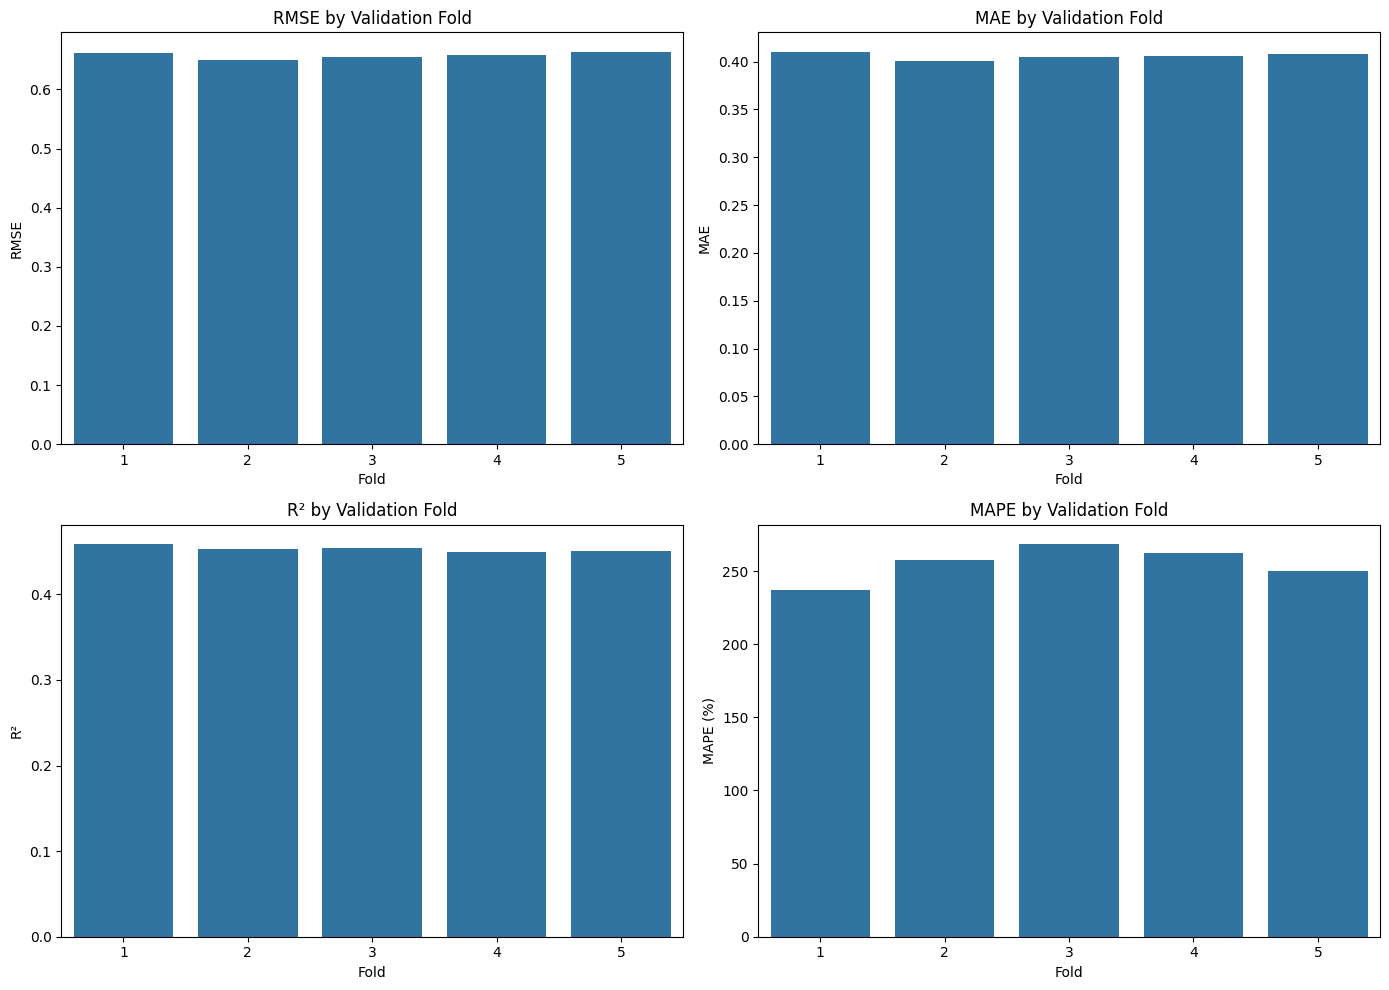

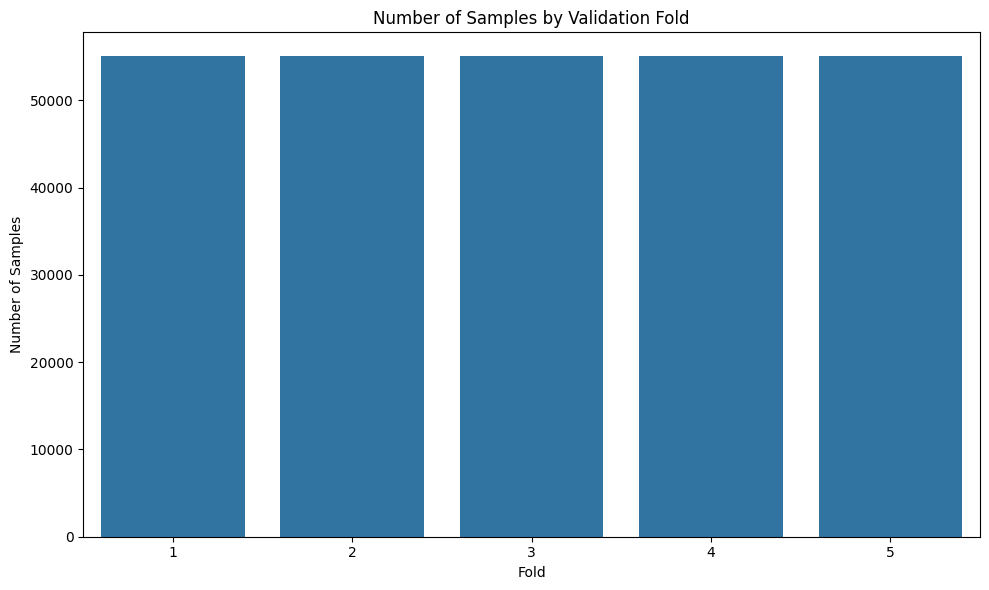

2. Time Series Metrics


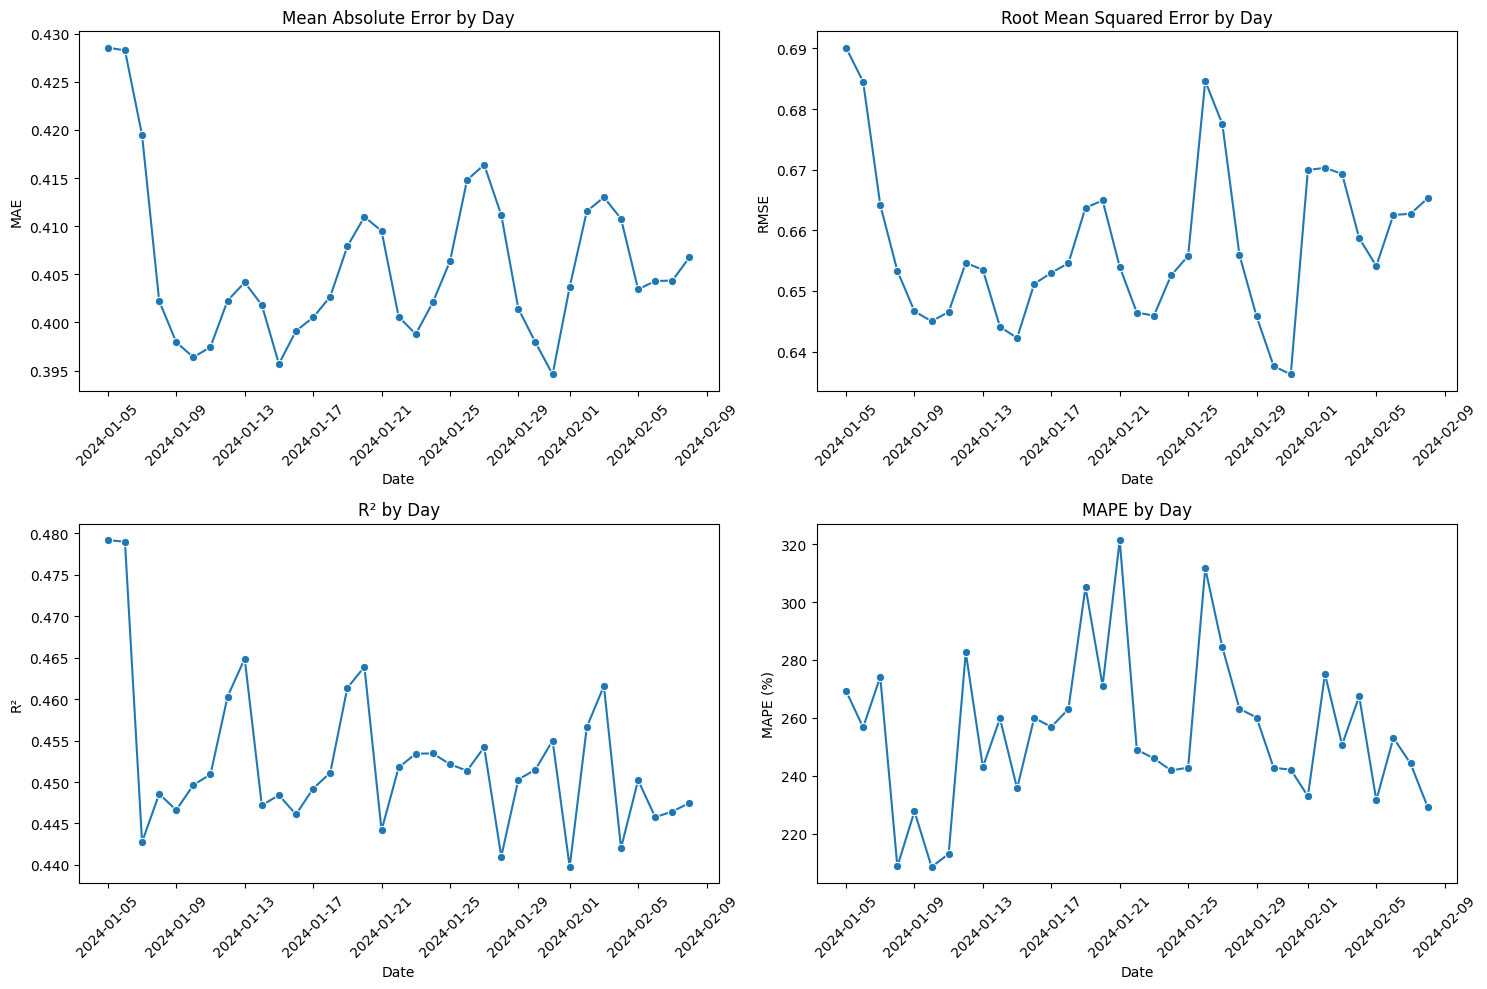

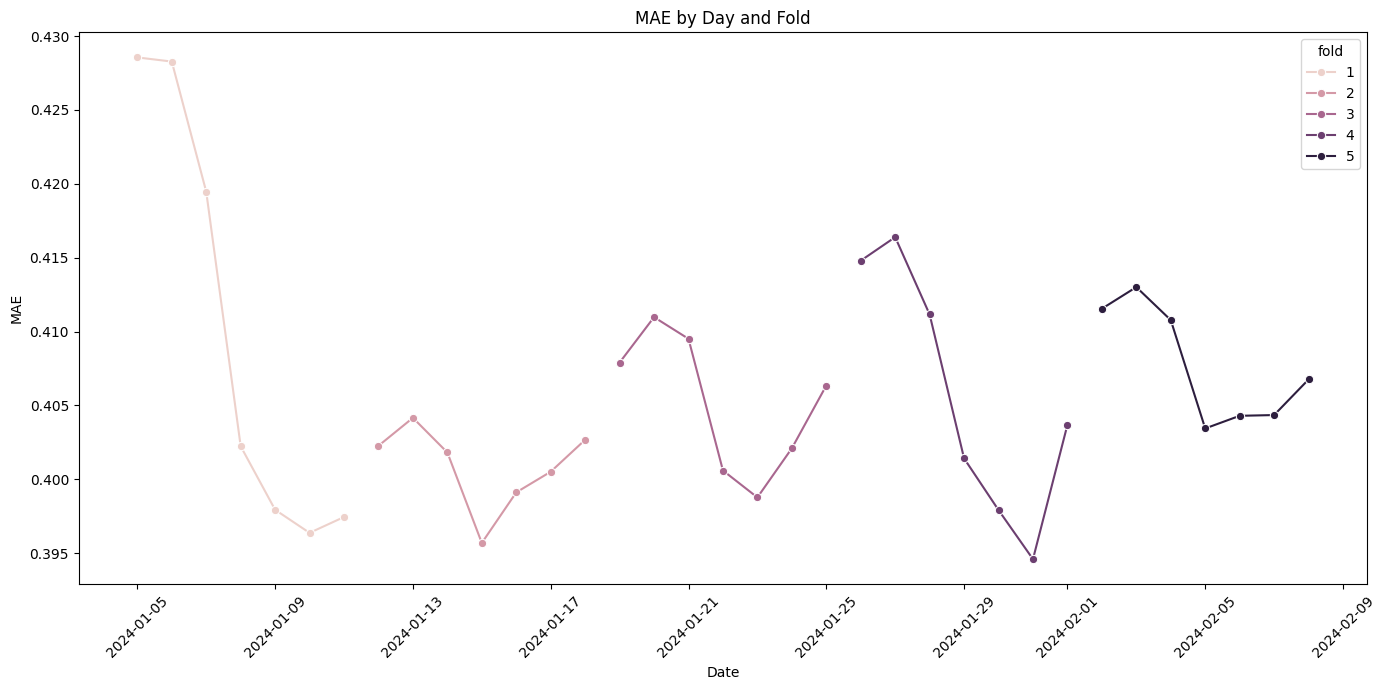

3. Feature Importance


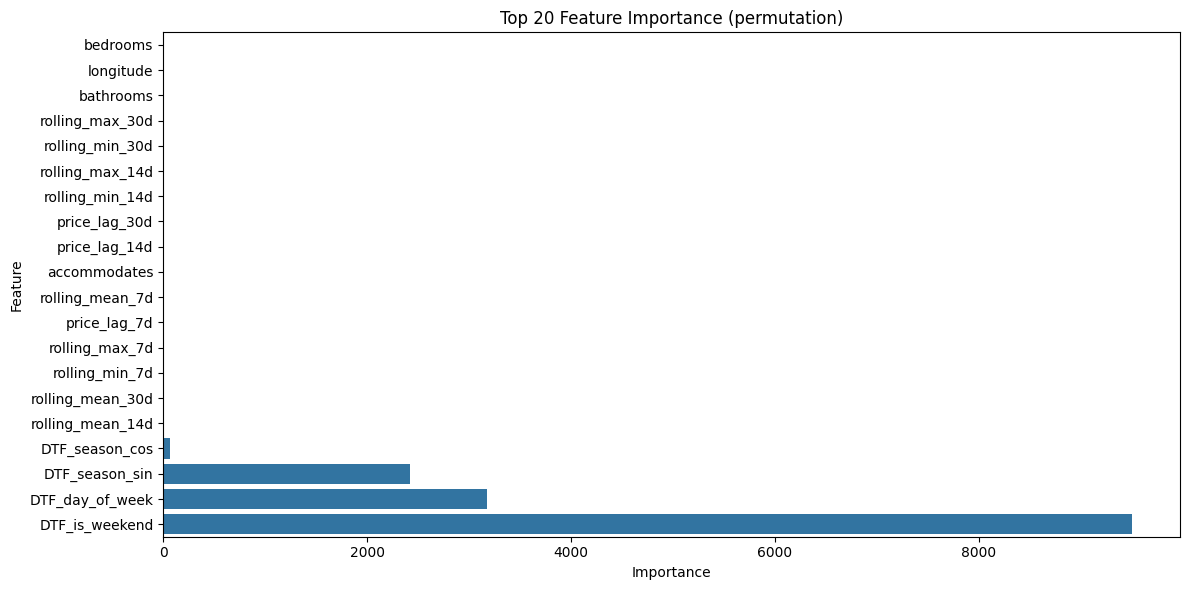

C:\Users\matth\AppData\Local\Temp\ipykernel_28436\1279224615.py:564: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Feature')


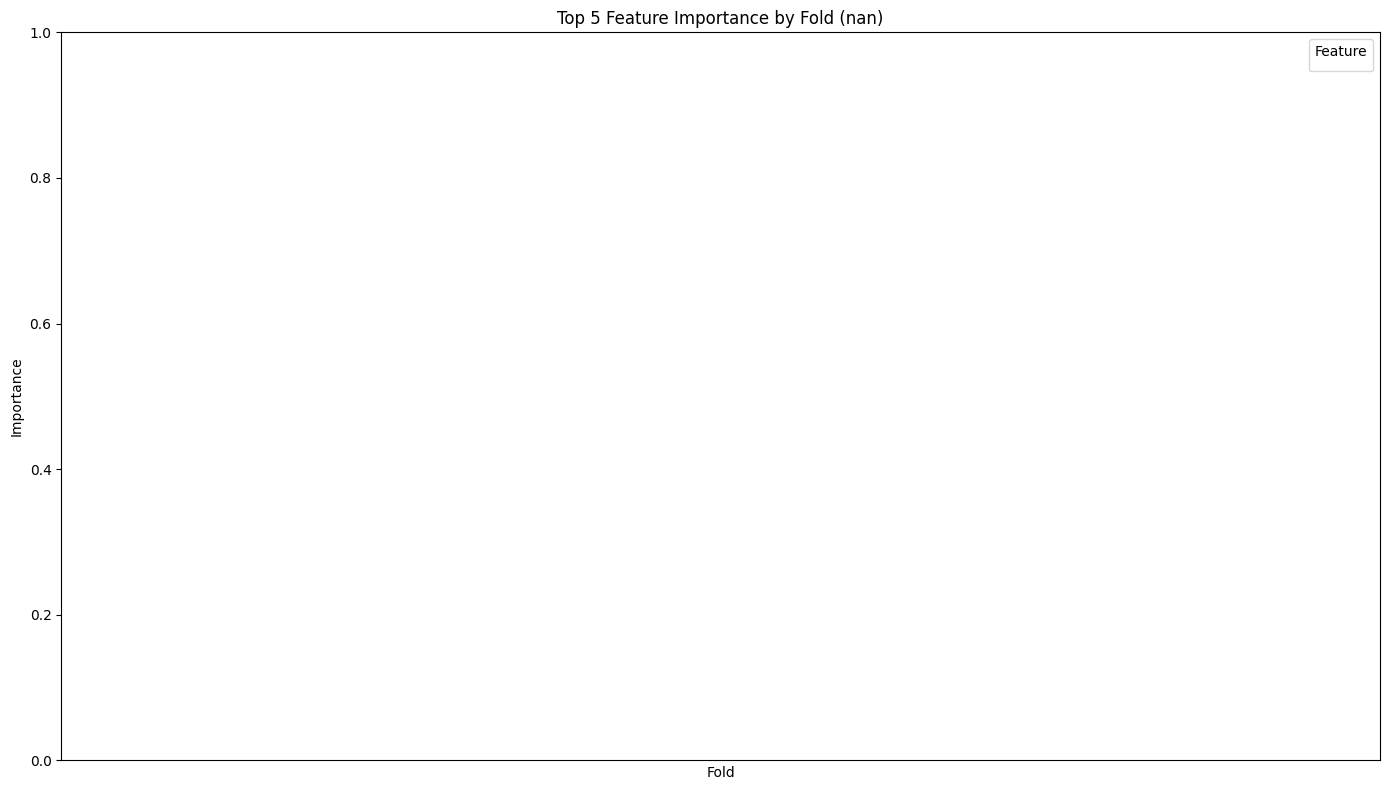

4. Error Analysis


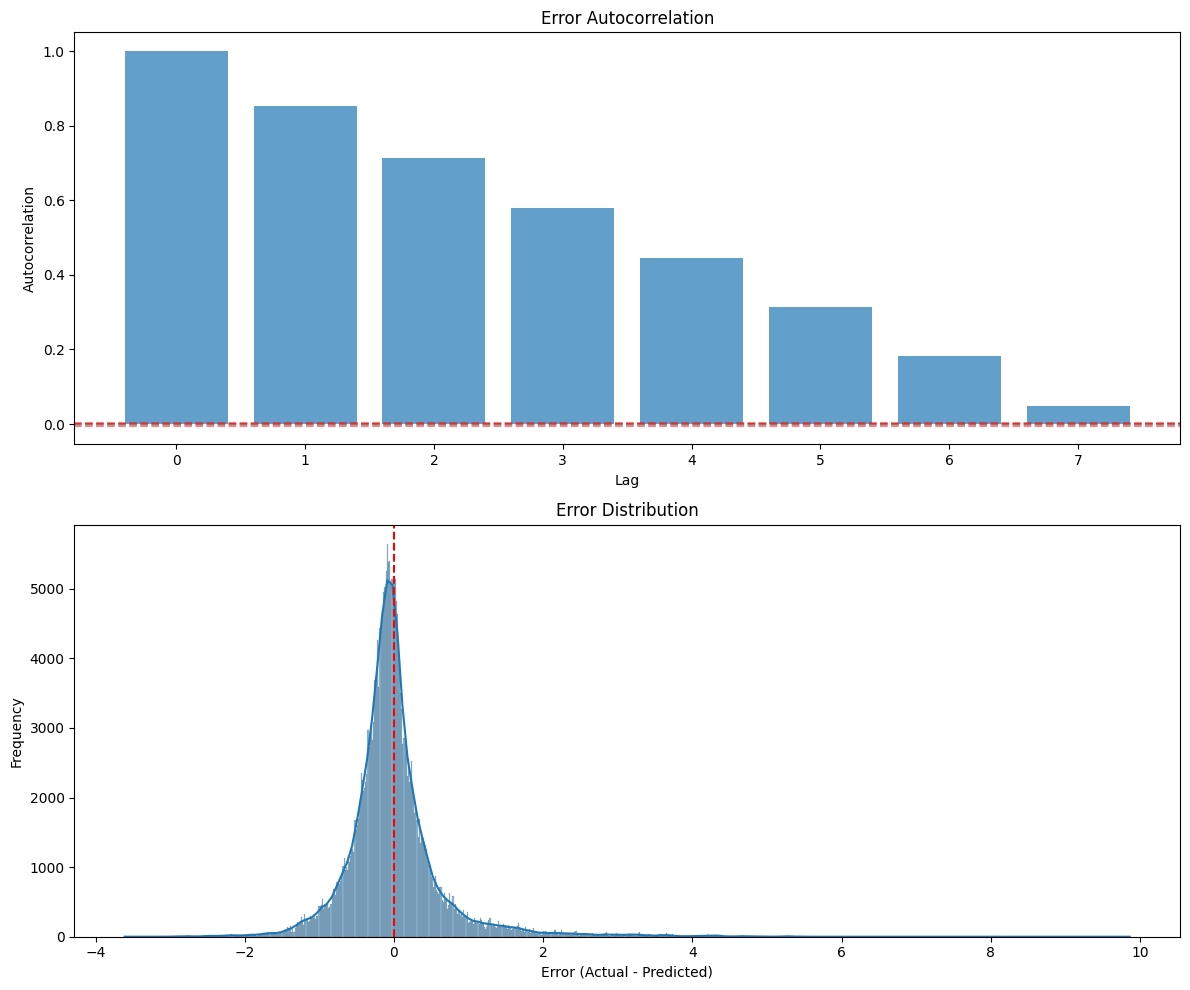

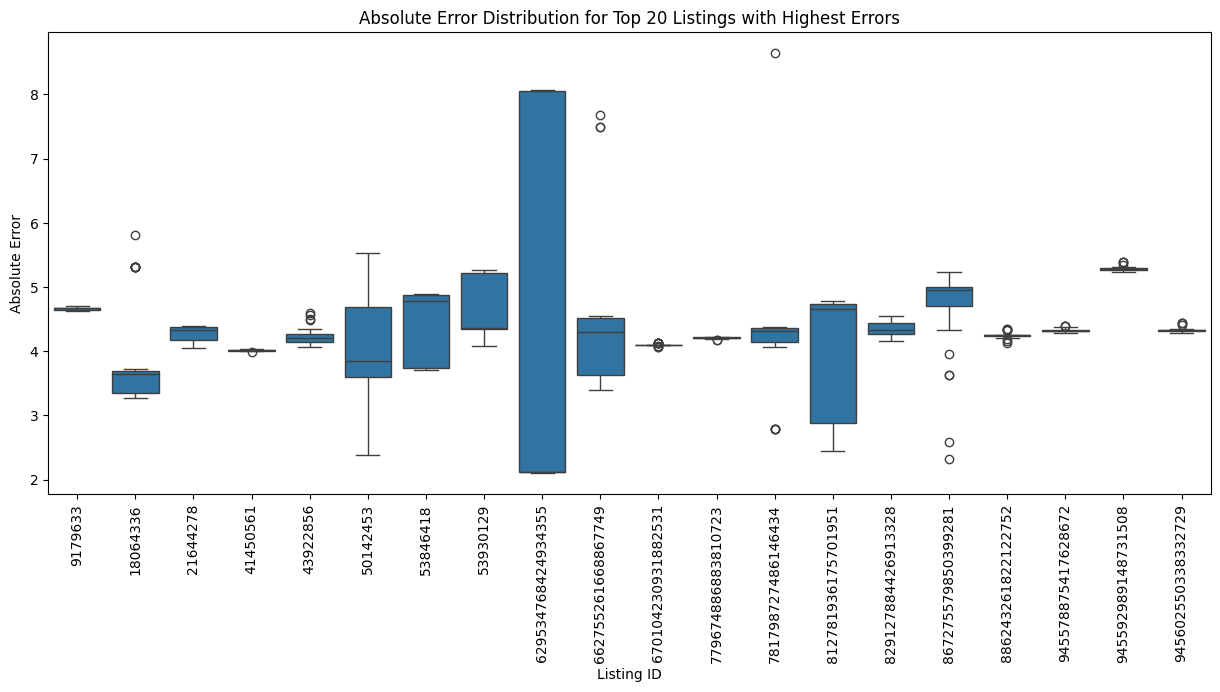

5. Actual vs Predicted Comparison


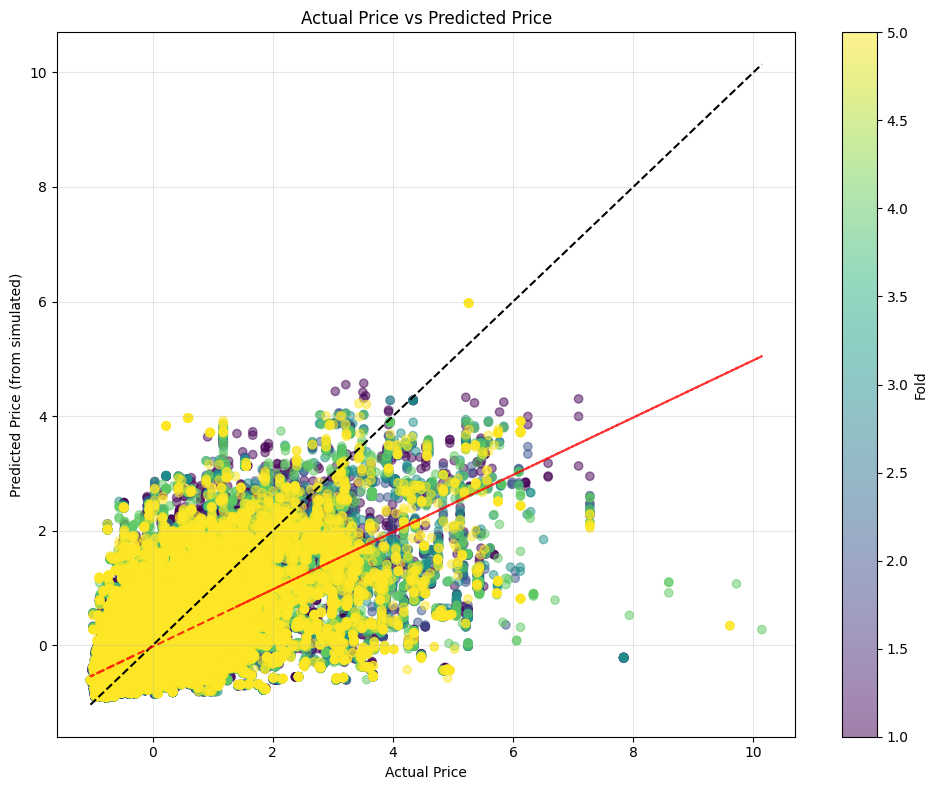

6. Sample Listing Comparisons


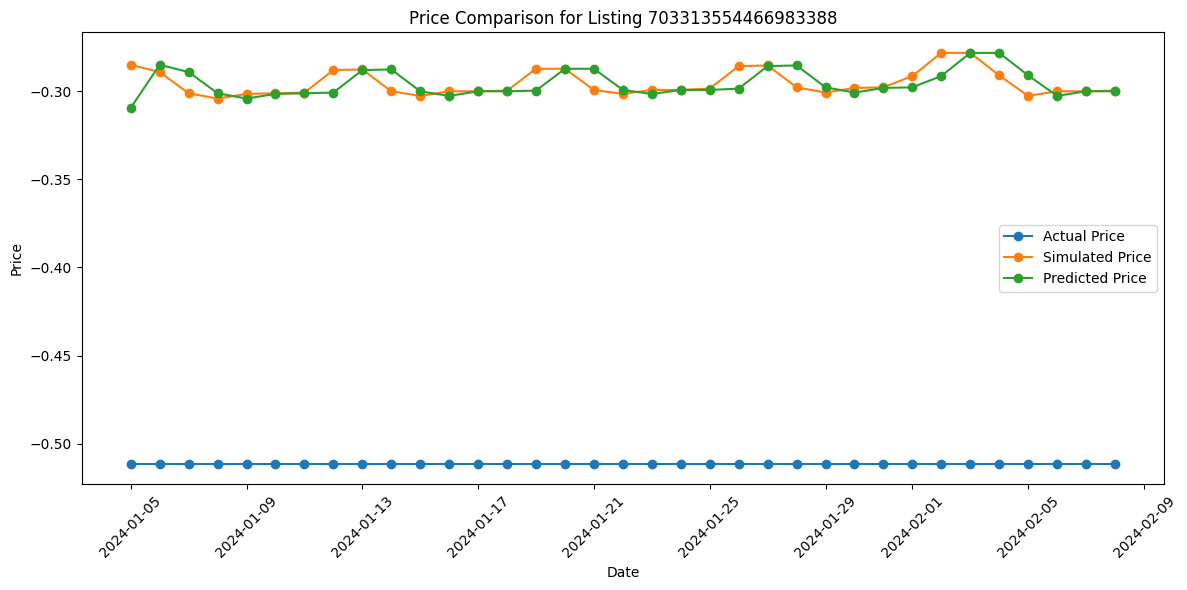

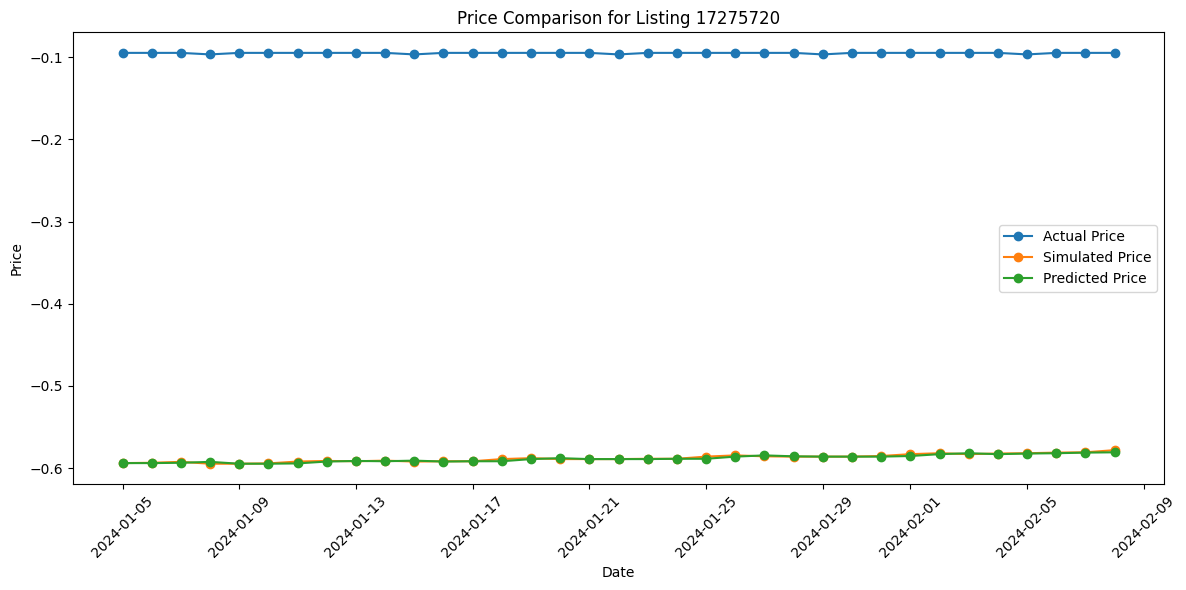

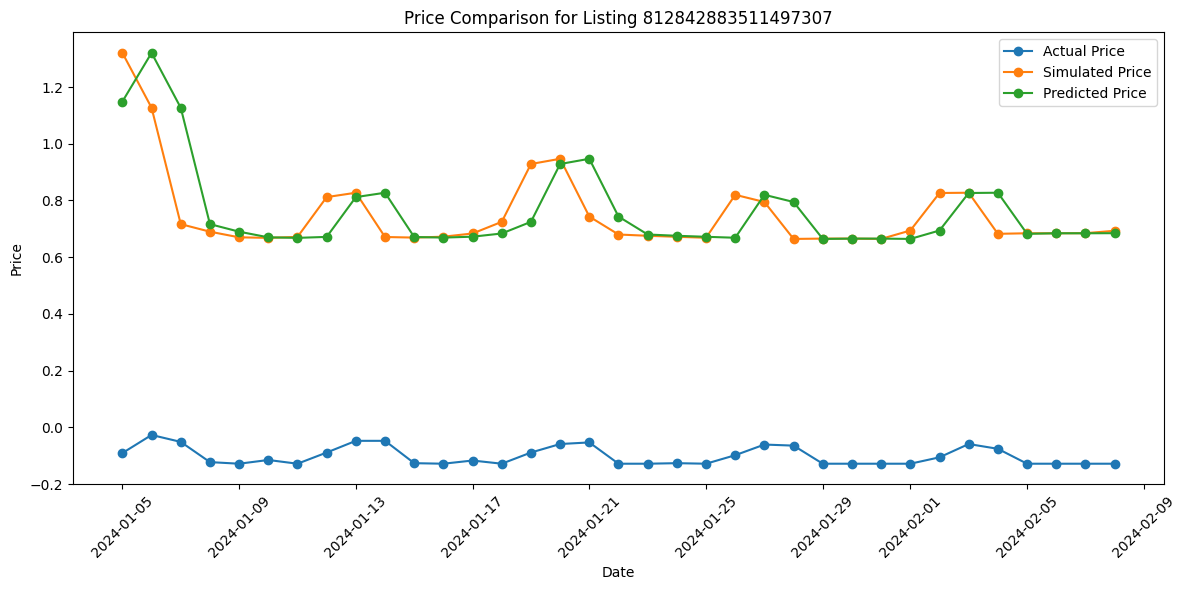

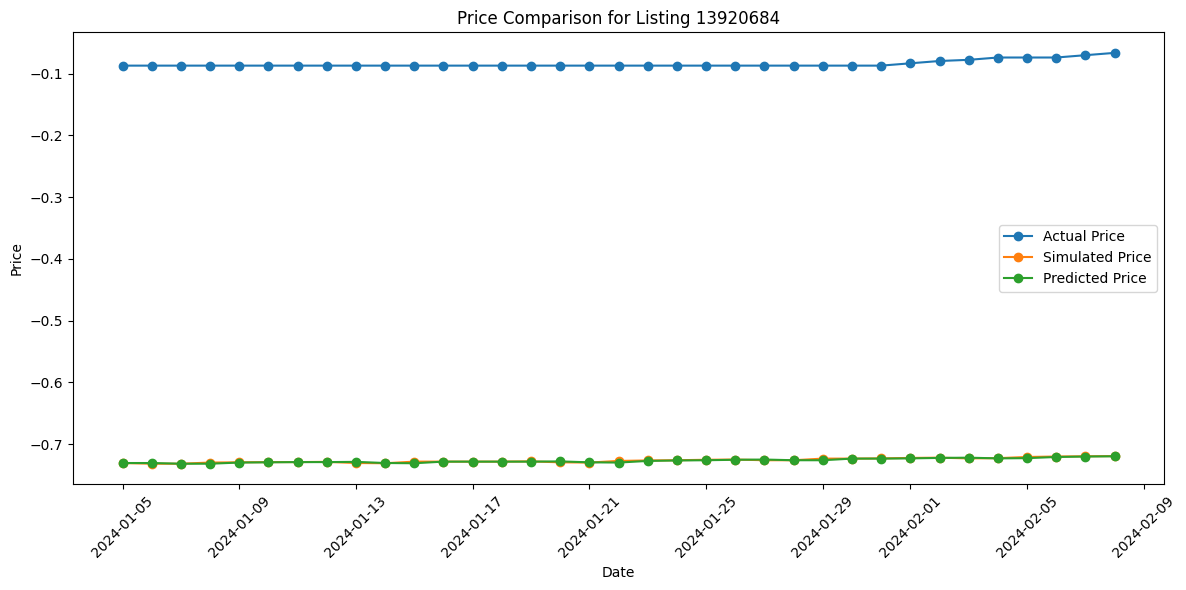

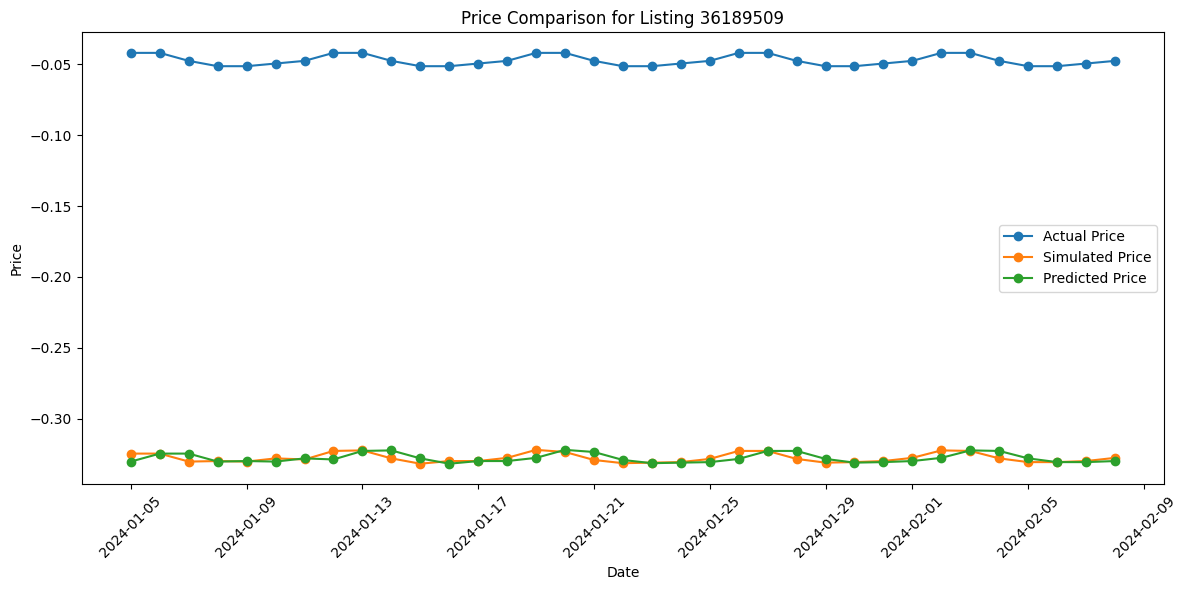


Comprehensive analysis complete.
Comparing different naive baseline models using the last 5 weeks for validation...
Training period: 2023-08-07 to 2024-01-04
Validation period: 2024-01-05 to 2024-02-08

Evaluating model: Previous Day Actual Price
Description: Previous day's actual price → predict actual price
RMSE: 0.0794
MAE: 0.0165
R²: 0.9920
MAPE: 14.16%
Samples: 275240

Evaluating model: Previous Day Simulated Price
Description: Previous day's simulated price → predict simulated price (evaluate against actual)
RMSE: 0.6578
MAE: 0.4059
R²: 0.4531
MAPE: 255.02%
Samples: 275240

Evaluating model: 7-Day Average Simulated Price
Description: Previous 7-day average of simulated price → predict simulated price (evaluate against actual)
RMSE: 0.6610
MAE: 0.4110
R²: 0.4476
MAPE: 260.24%
Samples: 275240


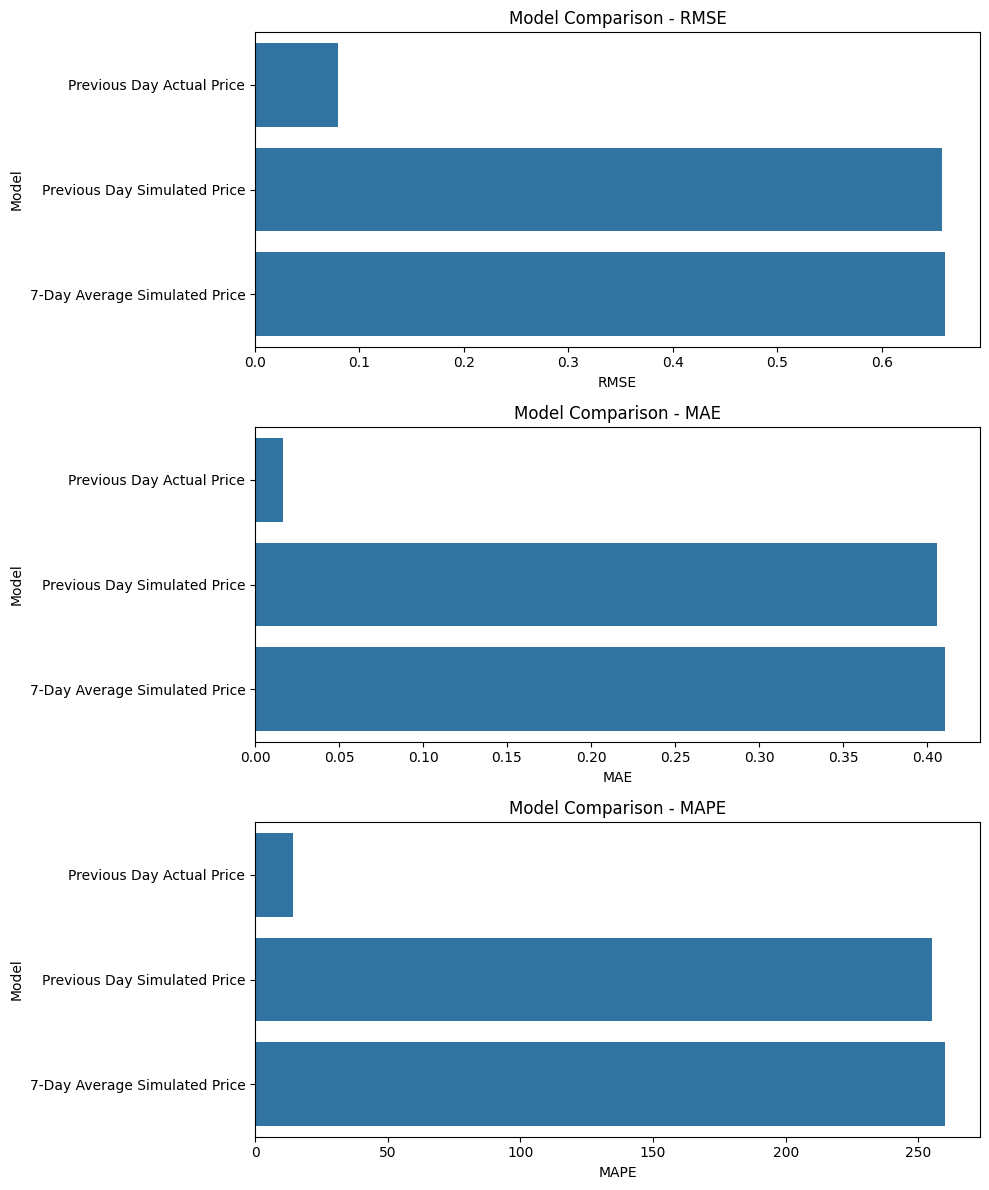

Comparison results saved to results\naive_models_comparison.csv

Analysis complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
import os
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

def run_naive_baseline_simulated_cv(data_path, n_folds=5, output_path=None):
    """
    Run naive baseline prediction using simulated prices with time-based consecutive validation weeks.
    Each fold uses exactly 1 week for validation, with the validation weeks being the last n_folds weeks
    of the dataset in consecutive order.
    
    Parameters:
    data_path (str): Path to the CSV data file
    n_folds (int): Number of time-based CV folds (each fold uses 1 week for validation)
    output_path (str, optional): Path to save results CSV
    """
    print(f"Running naive baseline with simulated prices using {n_folds} consecutive validation weeks")
    
    # Load data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Ensure we have the needed columns
    required_columns = ['listing_id', 'date', 'simulated_price', 'price']
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"Missing required columns: {missing}")
    
    # Identify potential feature columns (exclude target, IDs, and date)
    feature_cols = [col for col in data.columns 
                   if col not in ['listing_id', 'date', 'simulated_price', 'price', 
                                 'date_only', 'fold', 'previous_simulated_price', 
                                 'predicted_simulated', 'error', 'abs_error', 'pct_error']]
    
    print(f"Identified {len(feature_cols)} potential feature columns")
    
    # Sort by date
    data = data.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7
    
    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Ensure we have enough weeks for validation
    if weeks_available < n_folds:
        raise ValueError(f"Not enough weeks in dataset for {n_folds} validation weeks. "
                         f"Need at least {n_folds} weeks, but have {weeks_available} weeks.")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Initialize results storage
    fold_results = []
    feature_importance_results = []
    
    # Calculate previous day's simulated price for each listing
    data['previous_simulated_price'] = data.groupby('listing_id')['simulated_price'].shift(1)
    
    # Run cross-validation
    for fold_info in folds:
        fold = fold_info['fold']
        train_start = fold_info['train_start']
        train_end = fold_info['train_end']
        val_start = fold_info['val_start']
        val_end = fold_info['val_end']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {train_start.date()} to {train_end.date()}, "
              f"Val: {val_start.date()} to {val_end.date()})...")
        
        # Get training and validation data
        train_data = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
        val_data = data[(data['date'] >= val_start) & (data['date'] <= val_end)].copy()
        
        # Check that we have data
        if len(val_data) == 0:
            print(f"Warning: No validation data for fold {fold}. Skipping.")
            continue
        
        # For the first day of each listing in the validation period, we need to find the last simulated price
        # Create a mapping of last simulated prices from training data
        last_sim_prices = {}
        for listing_id in val_data['listing_id'].unique():
            listing_train = train_data[train_data['listing_id'] == listing_id].sort_values('date', ascending=False)
            if len(listing_train) > 0:
                last_sim_prices[listing_id] = listing_train.iloc[0]['simulated_price']
        
        # Fill in missing previous simulated prices in validation data
        for idx, row in val_data[val_data['previous_simulated_price'].isna()].iterrows():
            listing_id = row['listing_id']
            if listing_id in last_sim_prices:
                val_data.loc[idx, 'previous_simulated_price'] = last_sim_prices[listing_id]
            else:
                # If no training data for this listing, use mean simulated price
                mean_sim_price = train_data['simulated_price'].mean()
                val_data.loc[idx, 'previous_simulated_price'] = mean_sim_price
        
        # Use previous day's simulated price as the prediction for current day's simulated price
        val_data['predicted_simulated'] = val_data['previous_simulated_price']
        
        # Calculate errors against the actual price (not the simulated price)
        val_data['error'] = val_data['price'] - val_data['predicted_simulated']
        val_data['abs_error'] = np.abs(val_data['error'])
        val_data['pct_error'] = (np.abs(val_data['error']) / np.abs(val_data['price'] + 1e-8)) * 100
        
        # Add fold information
        val_data['fold'] = fold
        
        # Store results
        fold_results.append(val_data[['date', 'listing_id', 'price', 'simulated_price', 
                                    'predicted_simulated', 'error', 'abs_error', 'pct_error', 'fold']])
        
        # Feature importance analysis using a simple linear model
        if len(feature_cols) > 0:
            # Only include rows with valid features and target
            valid_features = val_data.dropna(subset=feature_cols + ['price', 'predicted_simulated'])
            
            if len(valid_features) > 0:
                # Train a linear model to predict the error
                X = valid_features[feature_cols]
                y = valid_features['error']  # We're trying to predict the error of our naive model
                
                try:
                    # Train model and get feature importances
                    model = LinearRegression()
                    model.fit(X, y)
                    
                    # Get feature importances
                    importances = np.abs(model.coef_)
                    importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': importances,
                        'fold': fold
                    })
                    feature_importance_results.append(importance_df)
                    
                    # Also try permutation importance for more robust results
                    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
                    perm_importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': perm_importance.importances_mean,
                        'fold': fold,
                        'method': 'permutation'
                    })
                    feature_importance_results.append(perm_importance_df)
                    
                except Exception as e:
                    print(f"Warning: Could not calculate feature importance for fold {fold}: {e}")
    
    # Combine all results
    all_results = pd.concat(fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_simulated'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    }
    
    # The rest of the function remains the same...
    # Calculate metrics for each fold
    fold_metrics = []
    for fold in range(1, n_folds + 1):
        fold_data = all_results[all_results['fold'] == fold]
        
        if len(fold_data) == 0:
            continue
        
        y_true_fold = fold_data['price'].values
        y_pred_fold = fold_data['predicted_simulated'].values
        
        fold_metrics.append({
            'fold': fold,
            'start_date': fold_data['date'].min(),
            'end_date': fold_data['date'].max(),
            'rmse': np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)),
            'mae': mean_absolute_error(y_true_fold, y_pred_fold),
            'r2': r2_score(y_true_fold, y_pred_fold) if len(set(y_true_fold)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_fold - y_pred_fold) / (np.abs(y_true_fold) + 1e-8))) * 100,
            'n_samples': len(y_true_fold)
        })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_simulated'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (np.abs(y_true_day) + 1e-8))) * 100,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Process feature importance results
    if feature_importance_results:
        feature_importance_df = pd.concat(feature_importance_results, ignore_index=True)
        
        # Calculate average importance across folds
        avg_importance = feature_importance_df.groupby(['feature', 'method'] 
                                                     if 'method' in feature_importance_df.columns 
                                                     else 'feature')['importance'].mean().reset_index()
        avg_importance = avg_importance.sort_values('importance', ascending=False)
    else:
        avg_importance = pd.DataFrame(columns=['feature', 'importance'])
        feature_importance_df = pd.DataFrame(columns=['feature', 'importance', 'fold'])
    
    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)
    
    # Calculate error stability metrics
    error_stability = calculate_error_stability(daily_metrics_df)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability,
        'feature_importance': avg_importance,
        'feature_importance_by_fold': feature_importance_df
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Also save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Also save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
        
        # Save feature importance
        if len(feature_importance_df) > 0:
            feature_path = output_path.replace('.csv', '_feature_importance.csv')
            avg_importance.to_csv(feature_path, index=False)
            print(f"Feature importance saved to {feature_path}")
    
    return evaluation_results


def compare_naive_models(data_path, n_validation_weeks=5, output_dir=None):
    """
    Compare different variations of naive models using the last n_validation_weeks of data.
    1. Previous day's actual price → predict actual price
    2. Previous day's simulated price → predict simulated price (evaluate against actual)
    3. Previous 7-day average of simulated price → predict simulated price (evaluate against actual)
    
    Parameters:
    data_path (str): Path to the data file
    n_validation_weeks (int): Number of weeks to use for validation (last weeks of the dataset)
    output_dir (str, optional): Directory to save results
    """
    print(f"Comparing different naive baseline models using the last {n_validation_weeks} weeks for validation...")
    
    # Load data
    data = pd.read_csv(data_path)
    data['date'] = pd.to_datetime(data['date'])
    
    # Sort by listing_id and date
    data = data.sort_values(['listing_id', 'date'])
    
    # Calculate additional lag features
    data['prev_price'] = data.groupby('listing_id')['price'].shift(1)
    data['prev_simulated'] = data.groupby('listing_id')['simulated_price'].shift(1)
    
    # Calculate rolling averages
    data['simulated_7d_avg'] = data.groupby('listing_id')['simulated_price'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean().shift(1)
    )
    
    # Set up naive model configurations
    naive_models = [
        {
            'name': 'Previous Day Actual Price',
            'prediction_col': 'prev_price',
            'description': 'Previous day\'s actual price → predict actual price'
        },
        {
            'name': 'Previous Day Simulated Price',
            'prediction_col': 'prev_simulated',
            'description': 'Previous day\'s simulated price → predict simulated price (evaluate against actual)'
        },
        {
            'name': '7-Day Average Simulated Price',
            'prediction_col': 'simulated_7d_avg',
            'description': 'Previous 7-day average of simulated price → predict simulated price (evaluate against actual)'
        }
    ]
    
    # Get min and max dates
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    # Define validation period (last n_validation_weeks)
    validation_start = max_date - timedelta(days=n_validation_weeks*7 - 1)
    validation_end = max_date
    training_end = validation_start - timedelta(days=1)
    
    print(f"Training period: {min_date.date()} to {training_end.date()}")
    print(f"Validation period: {validation_start.date()} to {validation_end.date()}")
    
    # Filter validation data
    val_data = data[(data['date'] >= validation_start) & (data['date'] <= validation_end)].copy()
    
    # Compare models
    model_results = []
    
    for model in naive_models:
        print(f"\nEvaluating model: {model['name']}")
        print(f"Description: {model['description']}")
        
        # Make predictions
        val_data[f"pred_{model['name']}"] = val_data[model['prediction_col']]
        
        # Calculate errors
        val_data[f"error_{model['name']}"] = val_data['price'] - val_data[f"pred_{model['name']}"]
        val_data[f"abs_error_{model['name']}"] = np.abs(val_data[f"error_{model['name']}"])
        
        # Calculate metrics
        y_true = val_data['price'].values
        y_pred = val_data[f"pred_{model['name']}"].values
        
        # Filter out any NaN values
        mask = ~np.isnan(y_pred)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        
        if len(y_true) == 0:
            print(f"No valid predictions for {model['name']}")
            continue
        
        metrics = {
            'model': model['name'],
            'description': model['description'],
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100,
            'n_samples': len(y_true)
        }
        
        model_results.append(metrics)
        
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MAE: {metrics['mae']:.4f}")
        print(f"R²: {metrics['r2']:.4f}")
        print(f"MAPE: {metrics['mape']:.2f}%")
        print(f"Samples: {metrics['n_samples']}")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results)
    
    # Plot comparison
    if len(comparison_df) > 0:
        metrics_to_plot = ['rmse', 'mae', 'mape']
        
        fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4*len(metrics_to_plot)))
        
        for i, metric in enumerate(metrics_to_plot):
            sns.barplot(x=metric, y='model', data=comparison_df, ax=axes[i])
            axes[i].set_title(f'Model Comparison - {metric.upper()}')
            axes[i].set_xlabel(metric.upper())
            axes[i].set_ylabel('Model')
        
        plt.tight_layout()
        plt.show()
    
    # Save comparison if output_dir is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        comparison_path = os.path.join(output_dir, 'naive_models_comparison.csv')
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Comparison results saved to {comparison_path}")
    
    return comparison_df


def run_comprehensive_analysis(data_path, n_folds=5, output_path=None):
    """
    Run a comprehensive analysis of the naive baseline model with simulated prices.
    
    Parameters:
    data_path (str): Path to the data file
    n_folds (int): Number of time-based CV folds (each using 1 week for validation)
    output_path (str, optional): Path to save results
    """
    # Run the cross-validation
    results = run_naive_baseline_simulated_cv(
        data_path=data_path,
        n_folds=n_folds,
        output_path=output_path
    )
    
    # Print summary
    print_summary(results)
    
    # Plot results
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance Metrics")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Feature Importance")
    plot_feature_importance(results)
    
    print("4. Error Analysis")
    plot_error_analysis(results)
    
    print("5. Actual vs Predicted Comparison")
    plot_actual_vs_predicted(results)
    
    print("6. Sample Listing Comparisons")
    plot_comparison_by_listing(results)
    
    print("\nComprehensive analysis complete.")
    
    return results


# Main execution
if __name__ == "__main__":
    # Specify path to your data
    data_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\temporal_features_combined.csv"  
    
    # Option 1: Run comprehensive analysis with time-based CV using consecutive weeks
    results = run_comprehensive_analysis(
        data_path=data_path,
        n_folds=5,  # Will use the last 5 weeks as validation periods
        output_path="results/naive_baseline_simulated_cv_results.csv"
    )
    
    # Option 2: Compare different naive models using the last 5 weeks for validation
    model_comparison = compare_naive_models(
        data_path=data_path,
        n_validation_weeks=5,  # Use the last 5 weeks for validation
        output_dir="results"
    )
    
    print("\nAnalysis complete.")